In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

In [2]:
data = pd.read_csv('training_data.csv')

## Part 1) exploratory  data analysis 

In [3]:
data.head()

Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   

    PE  NM_M  RELPOS  
0  4.6     1   1.000  
1  4.1     1   0.979  
2  3.6     1   0.957  
3  3.5     1   0.936  
4  3.4     1   0.915

In [4]:
data.describe().T

count         mean         std          min         25%  \
Facies     3232.0     4.422030    2.504243     1.000000     2.00000   
Depth      3232.0  2875.824567  131.006274  2573.500000  2791.00000   
GR         3232.0    66.135769   30.854826    13.250000    46.91875   
ILD_log10  3232.0     0.642719    0.241845    -0.025949     0.49275   
DeltaPHI   3232.0     3.559642    5.228948   -21.832000     1.16375   
PHIND      3232.0    13.483213    7.698980     0.550000     8.34675   
PE         3232.0     3.725014    0.896152     0.200000     3.10000   
NM_M       3232.0     1.498453    0.500075     1.000000     1.00000   
RELPOS     3232.0     0.520287    0.286792     0.010000     0.27300   

                   50%          75%       max  
Facies        4.000000     6.000000     9.000  
Depth      2893.500000  2980.000000  3122.500  
GR           65.721500    79.626250   361.150  
ILD_log10     0.624437     0.812735     1.480  
DeltaPHI      3.500000     6.432500    18.600  
PHIND        12.150000    16.453750    84.400  
PE            3.551500     4.300000     8.094  
NM_M          1.000000     2.000000     2.000  
RELPOS        0.526000     0.767250     1.000

- 9 Facies exist : Facies 1 to 9
- GR Values range from 13 to 361 (Range should be up to 150: we need to check if the High GR above 150 are tied to specific facies, or if they are outliers)

<span style="color:purple">Remember for future references that sometimes you can also have very radioactive lithologies, for example. Right now we don't have much of the geology / spectral gamma ray,  and it is also not the full objective of the project, but I think is important to remember this.</span>


- ILD log of up to 1.48 (-ve values are seen, Need to deal with such values check if they are reuccuring, else, the row may be eliminated)
- DeltaPHI : Check why there is a negative deltaPHI. : * There are almost 500 negative DELTAPHI no correlation between any property: DeltaPhi also has a low correlation with facies: hence, we might exclude it from feature selection, and just use PHIND since they both have thesame sence *
- PHID Check reason for extremely High value > 40 (Comes mostly from facies 3)
- PE Seems to be ok
- NM_M Seems ok as well

### Setting a designated color for each facies

In [5]:
facies_colors = {
    1: 'yellow',
    2: 'orange',
    3: 'brown',
    4: 'red',
    5: 'darkgrey',
    6: 'darkblue',
    7: 'magenta',
    8: 'cyan',
    9: 'lightblue',
}

Depo_env_colors = {
    1: 'Black',
    2: 'Red',
}

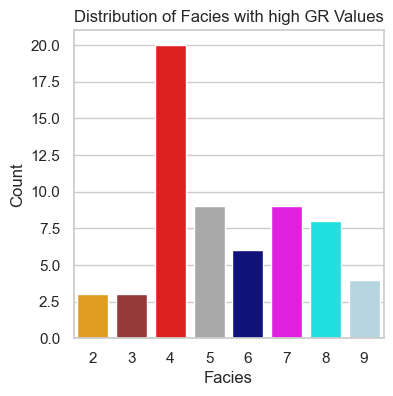

In [6]:
High_GR= data[data["GR"] >150]

# Set visual style
sns.set(style="whitegrid")

# 2. Plot the distribution of the target variable (Facies)
plt.figure(figsize=(4, 4))
# BETANIA COMMENT: Modifying slightly the next line of code, to avoid deprecation warning.
sns.countplot(data=High_GR, x="Facies",  palette=facies_colors)
plt.title("Distribution of Facies with high GR Values")
plt.xlabel("Facies")
plt.ylabel("Count")
plt.show()

### Displaying histogram of each log data

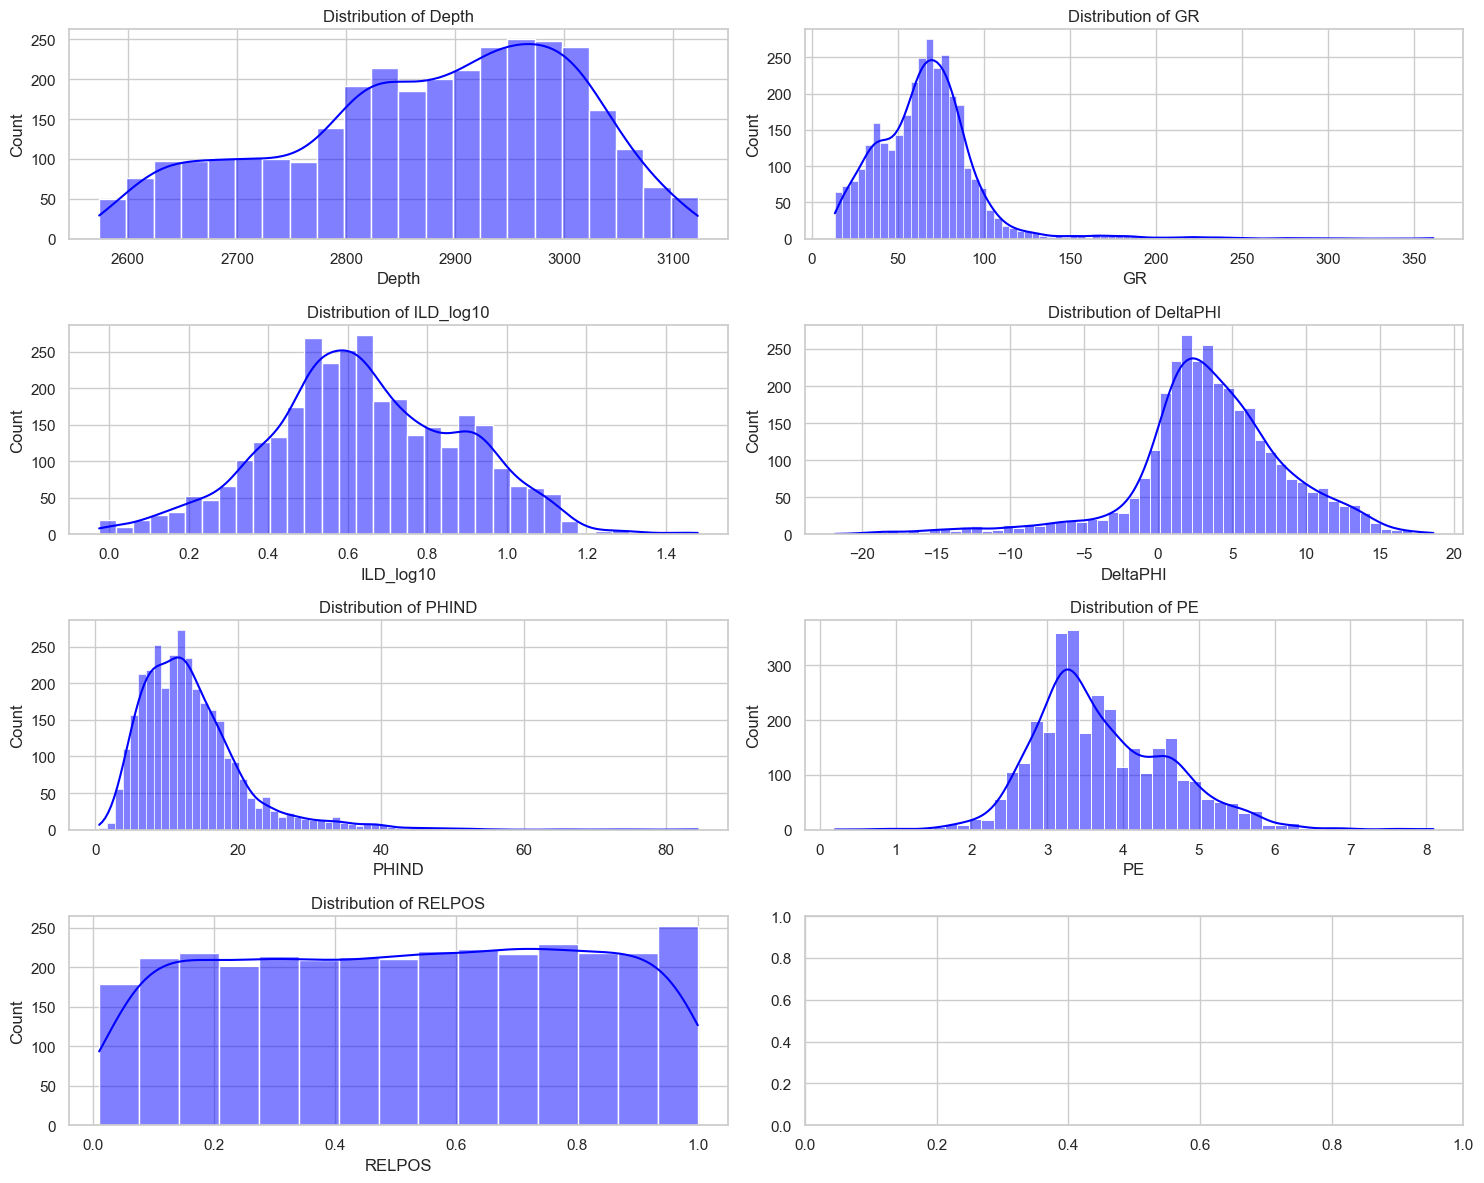

In [7]:
numerical_features = ["Depth", "GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "RELPOS"]
fig, axes = plt.subplots(4, 2, figsize=(15, 12))
axes = axes.ravel()
for i, feature in enumerate(numerical_features):
    sns.histplot(data[feature], kde=True, ax=axes[i], color="blue")
    axes[i].set_title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

 Histograms seem to be mostly multimodal, but it is impossible to identify individual classes just from these distributions. The GR and PHID logs are positively skewed, while DeltaPHI is negatively skewed.  

### Displaying Boxplot to identify outliers
<span style="color: red;">One outlier can be identified on the GR data with GR value > 300. Some negative values can be seen on ILD log, While values  of PHID> 60 are also noticeable</span>

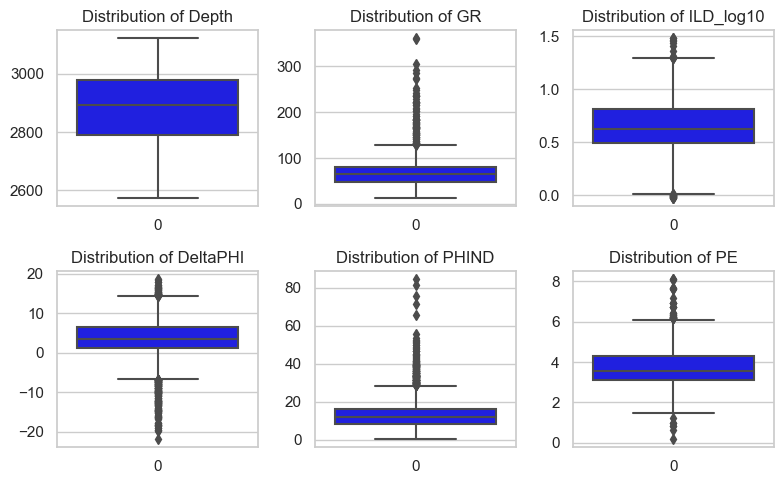

In [8]:
numerical_features = ["Depth", "GR", "ILD_log10", "DeltaPHI", "PHIND", "PE"]
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.ravel()
for i, feature in enumerate(numerical_features):
    sns.boxplot(data[feature],  ax=axes[i], color="blue")
    axes[i].set_title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()


- GR> 120 Seam to be outliers
- ILD <0 Seams to be outliers
- PHID > 30 seams to be outliers


### Analysing GR values for marine and non marine samples:

GR responses > 150 is only seen in Non marine samples

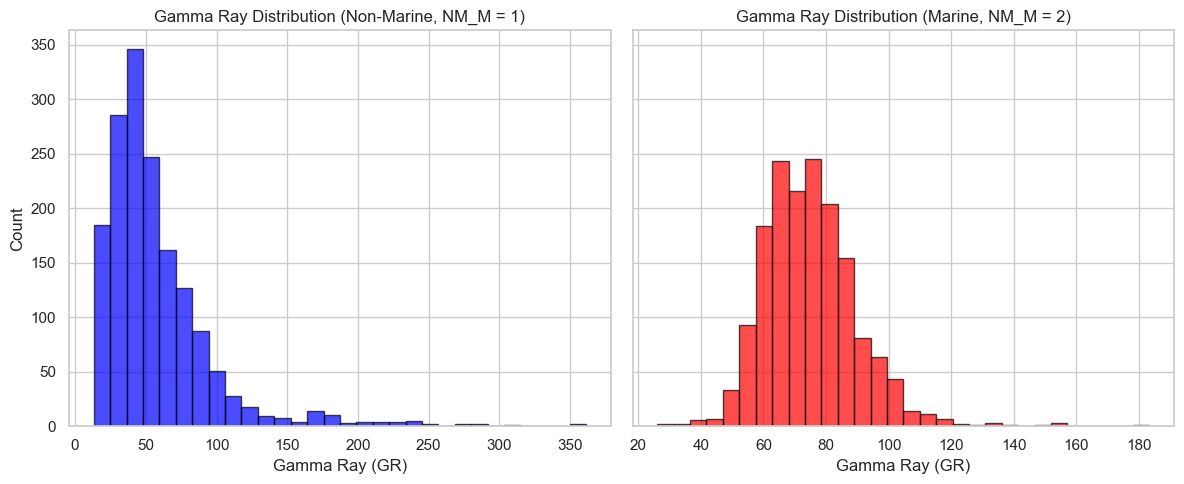

In [9]:
# Define Marine and Non-Marine data
non_marine_data = data[data["NM_M"] == 1]
marine_data = data[data["NM_M"] == 2]

# Set up figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot Marine histogram for GR
axes[0].hist(marine_data["GR"], bins=30, color="blue", edgecolor="black", alpha=0.7)
axes[0].set_title("Gamma Ray Distribution (Non-Marine, NM_M = 1)")
axes[0].set_xlabel("Gamma Ray (GR)")
axes[0].set_ylabel("Count")

# Plot Non-Marine histogram for GR
axes[1].hist(non_marine_data["GR"], bins=30, color="red", edgecolor="black", alpha=0.7)
axes[1].set_title("Gamma Ray Distribution (Marine, NM_M = 2)")
axes[1].set_xlabel("Gamma Ray (GR)")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

- High GR Values mostly belong to Non marine 

### Features include:
1) Gamma ray (GR)
2) Resistivity (ILD_log10)
3) Photoelectric effect (PE)
4) Neutron-density porosity difference (DeltaPHI)
5) Average neutron-density porosity (PHIND)
6) Nonmarine/marine indicator (NM_M)
7) Relative position (RELPOS)

### Checking for NaN Values

In [10]:
for well_name, df in data.items():
    print(f"\nMissing values in {well_name}:")
    missing_values = df.isnull().sum()
    print(missing_values)

    # Handle missing values by forward filling
    #df.ffill(inplace=True)  # Using the recommended forward fill method
    #well_data[well_name] = df


Missing values in Facies:
0

Missing values in Formation:
0

Missing values in Well Name:
0

Missing values in Depth:
0

Missing values in GR:
0

Missing values in ILD_log10:
0

Missing values in DeltaPHI:
0

Missing values in PHIND:
0

Missing values in PE:
0

Missing values in NM_M:
0

Missing values in RELPOS:
0


### Checking facies counts: 
Facies 2 is the most occuring, while facies 7 is the least occuring. This might be harder to predict due to limited training set

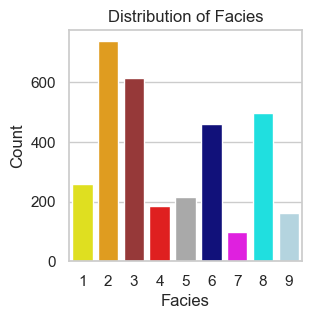

In [11]:
# Set visual style
sns.set(style="whitegrid")

# 1. Check for missing values
missing_values = data.isnull().sum()

# 2. Plot the distribution of the target variable (Facies)
plt.figure(figsize=(3, 3))
# BETANIA COMMENT: same as before, slight change to avoid deprecation warning.
sns.countplot(data=data, x="Facies",   palette=facies_colors )
plt.title("Distribution of Facies")
plt.xlabel("Facies")
plt.ylabel("Count")
plt.show()

##### We see that Facies 2, 3, 8 and 6 are majority classes, and classes 7, 1, 4, 5 and 9 are minority. Data Imbalance: Facies are not properly distributed: for SVM, higher weights needs to be assigned to minority class. For RF, same can be done, or bootstrapping can be done.

### Plotting Correlation matric for feature selection 

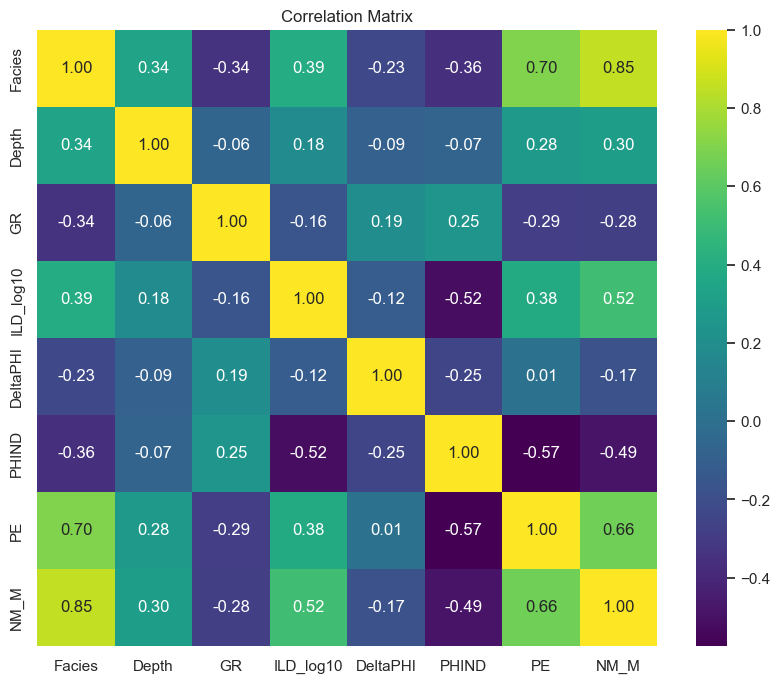

In [12]:
# 3. Visualize correlations between numerical features
plt.figure(figsize=(10, 8))

#Betania comment: numerical features only
data_corr = data.drop(["Formation", "Well Name", "RELPOS"], axis=1)
corr_matrix = data_corr.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', cbar=True)
plt.title("Correlation Matrix")
plt.show()


### Boxplot distribution by facies

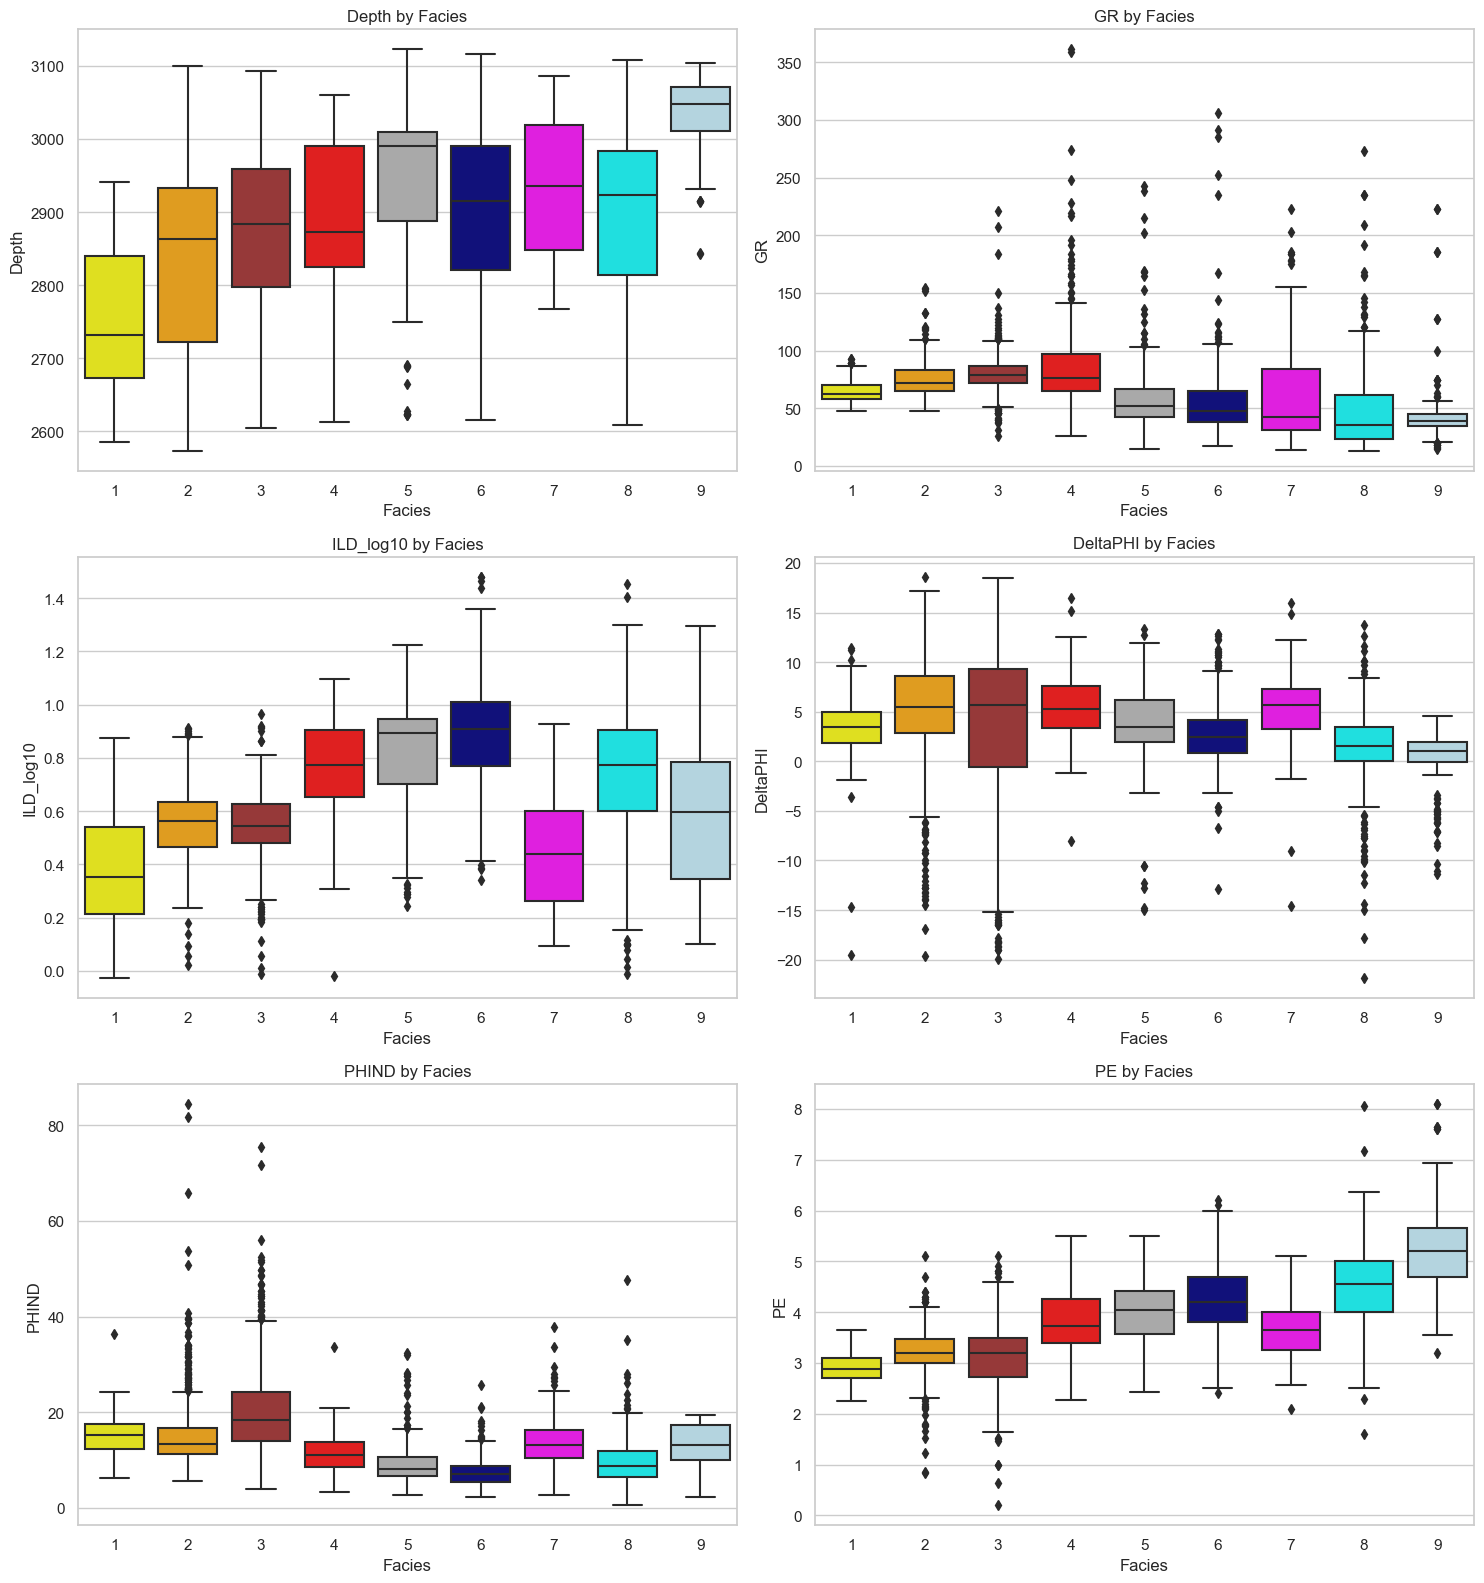

In [13]:
# 5. Boxplots to analyze feature distribution by Facies
fig, axes = plt.subplots(3, 2, figsize=(15, 16))
axes = axes.ravel()
for i, feature in enumerate(numerical_features):
    # Betania comment: avoiding deprecation warning
    sns.boxplot(data=data, x="Facies",  y=feature, ax=axes[i], palette=facies_colors)
    axes[i].set_title(f"{feature} by Facies")
plt.tight_layout()
plt.show()


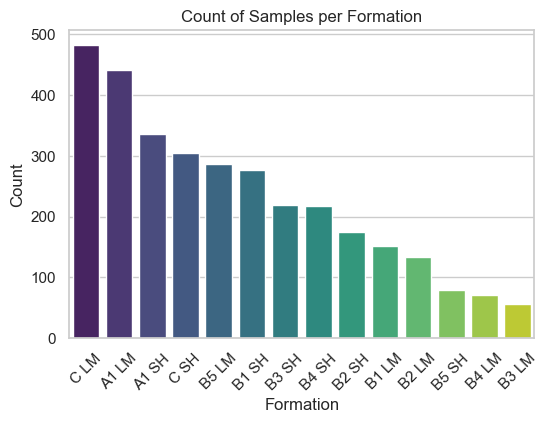

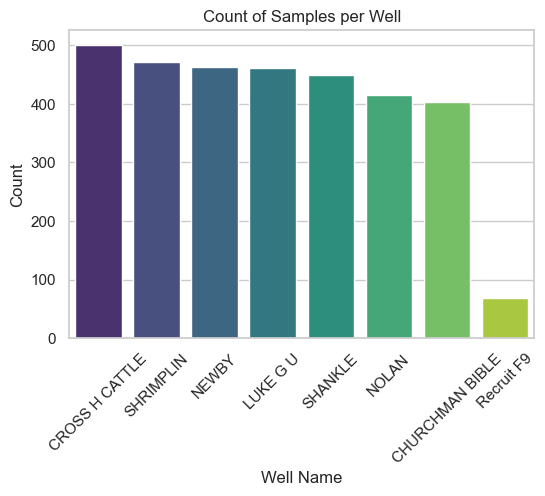

In [14]:
# 6. Analyze categorical variables (Formation and Well Name)
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="Formation", order=data["Formation"].value_counts().index, palette="viridis")
plt.title("Count of Samples per Formation")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="Well Name", order=data["Well Name"].value_counts().index, palette="viridis")
plt.title("Count of Samples per Well")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


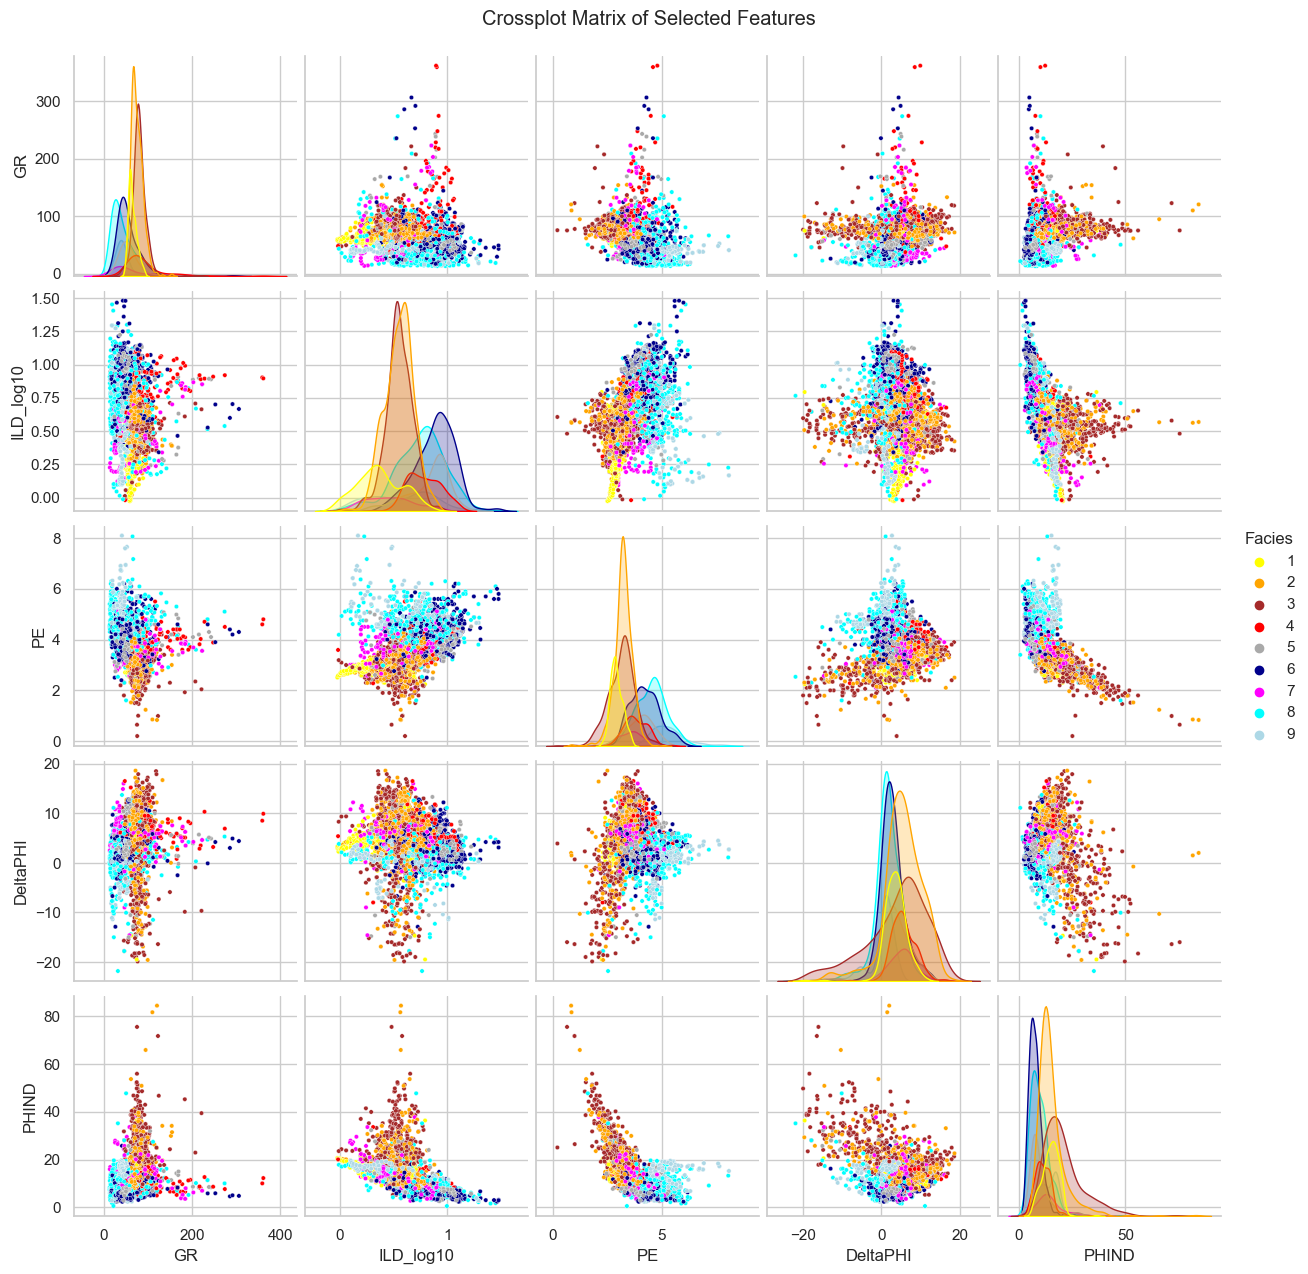

In [15]:
# 7. Crossplot matrix excluding Depth
grid_features = ["GR", "ILD_log10", "PE", "DeltaPHI", "PHIND"]
g = sns.pairplot(data, vars=grid_features, hue="Facies", palette=facies_colors, diag_kind="kde", plot_kws={"s": 10})
g.fig.suptitle("Crossplot Matrix of Selected Features", y=1.02)
plt.show()

# Log Visualization 

In [16]:
data['Well Name'].unique()

array(['SHRIMPLIN', 'SHANKLE', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN',
       'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE'], dtype=object)

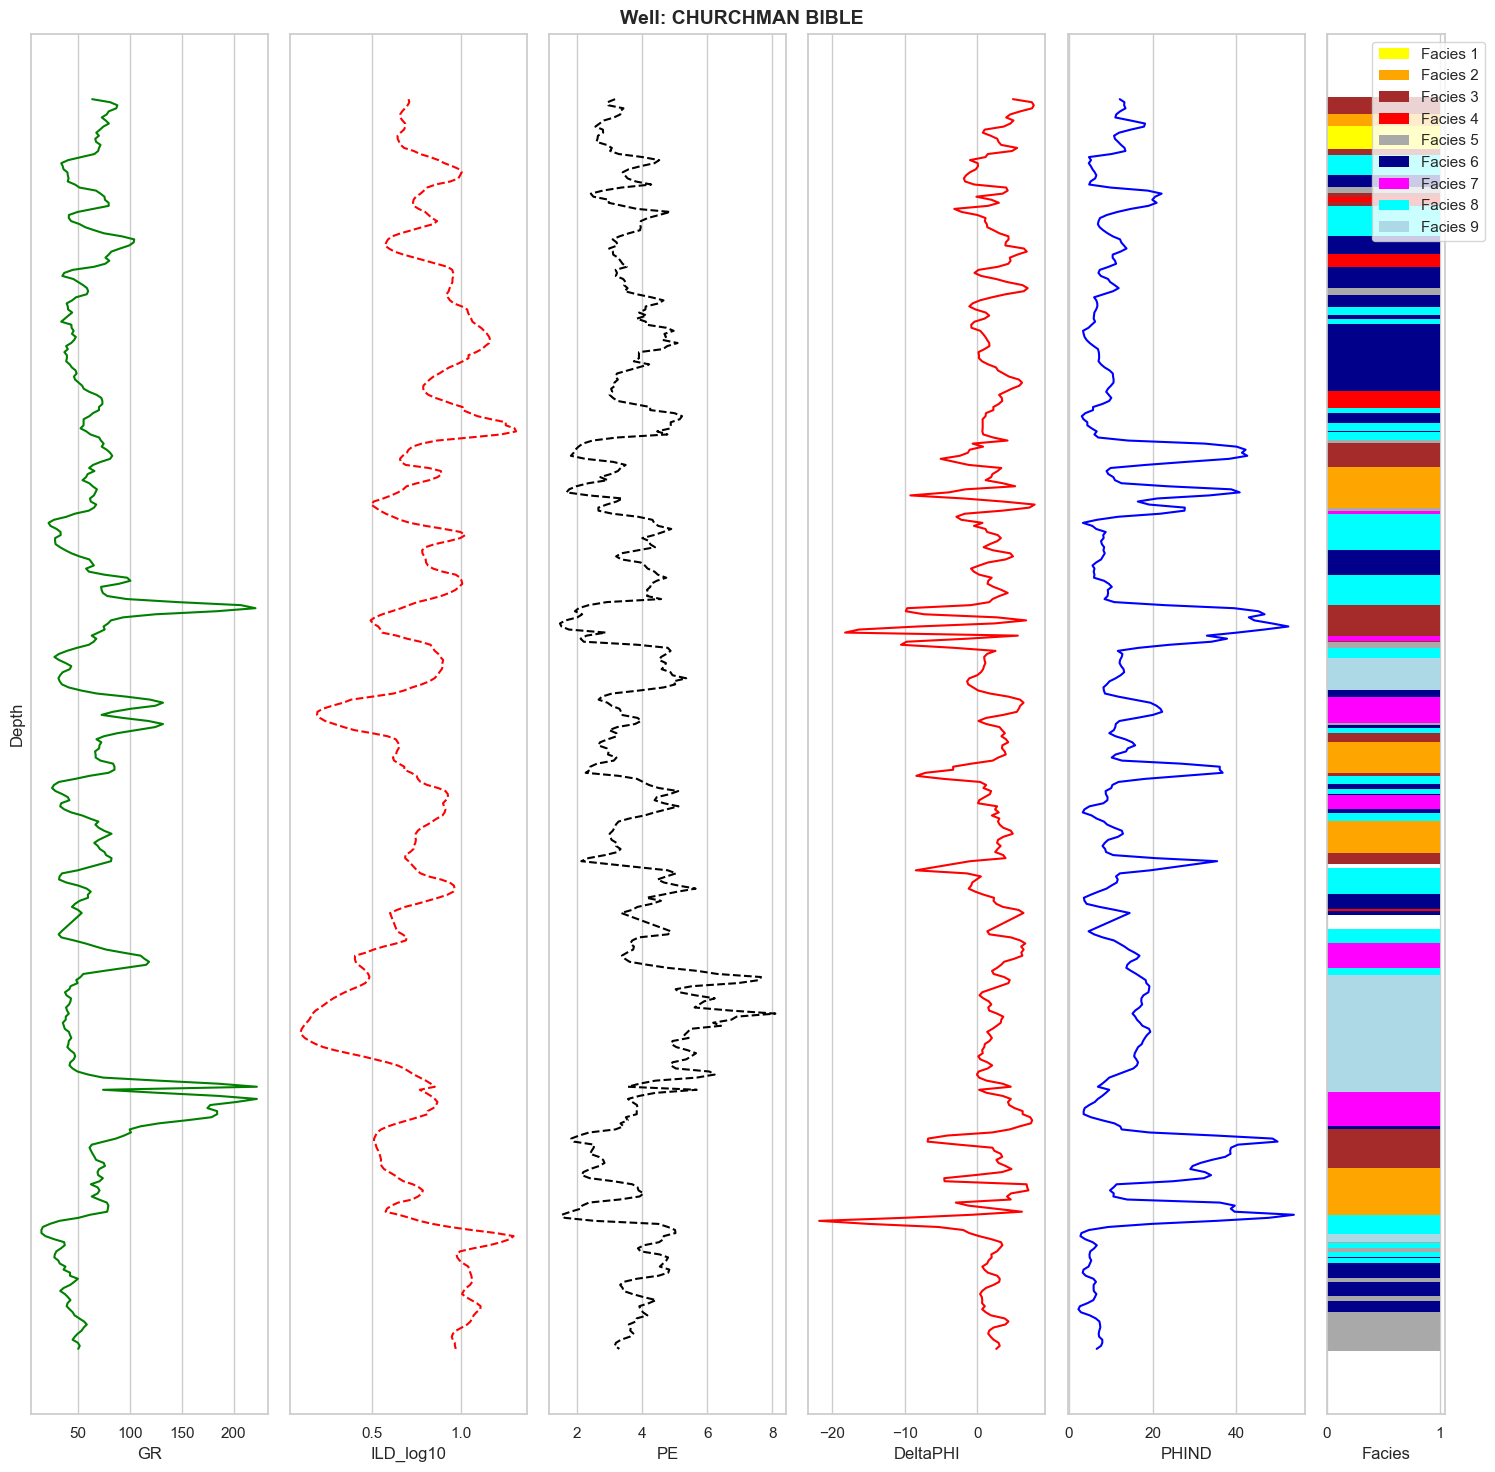

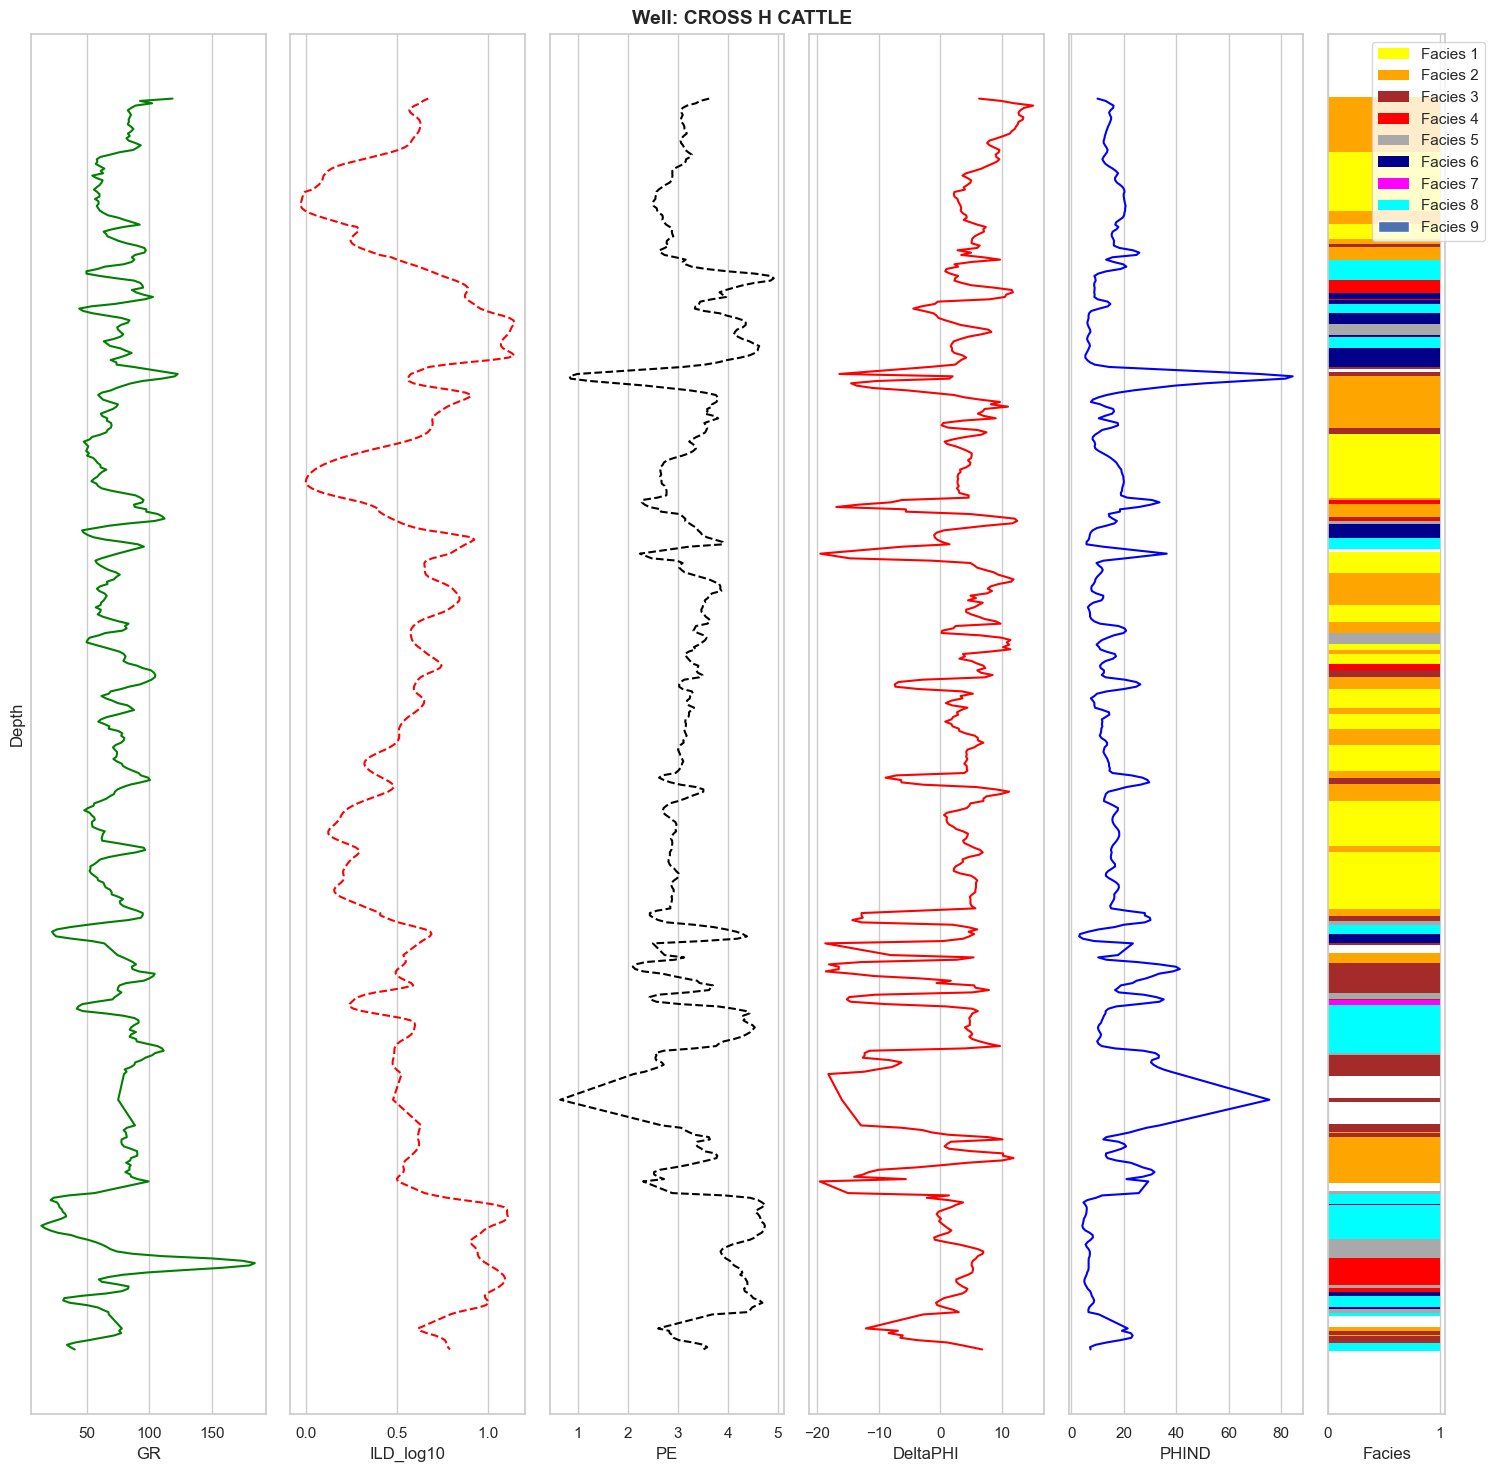

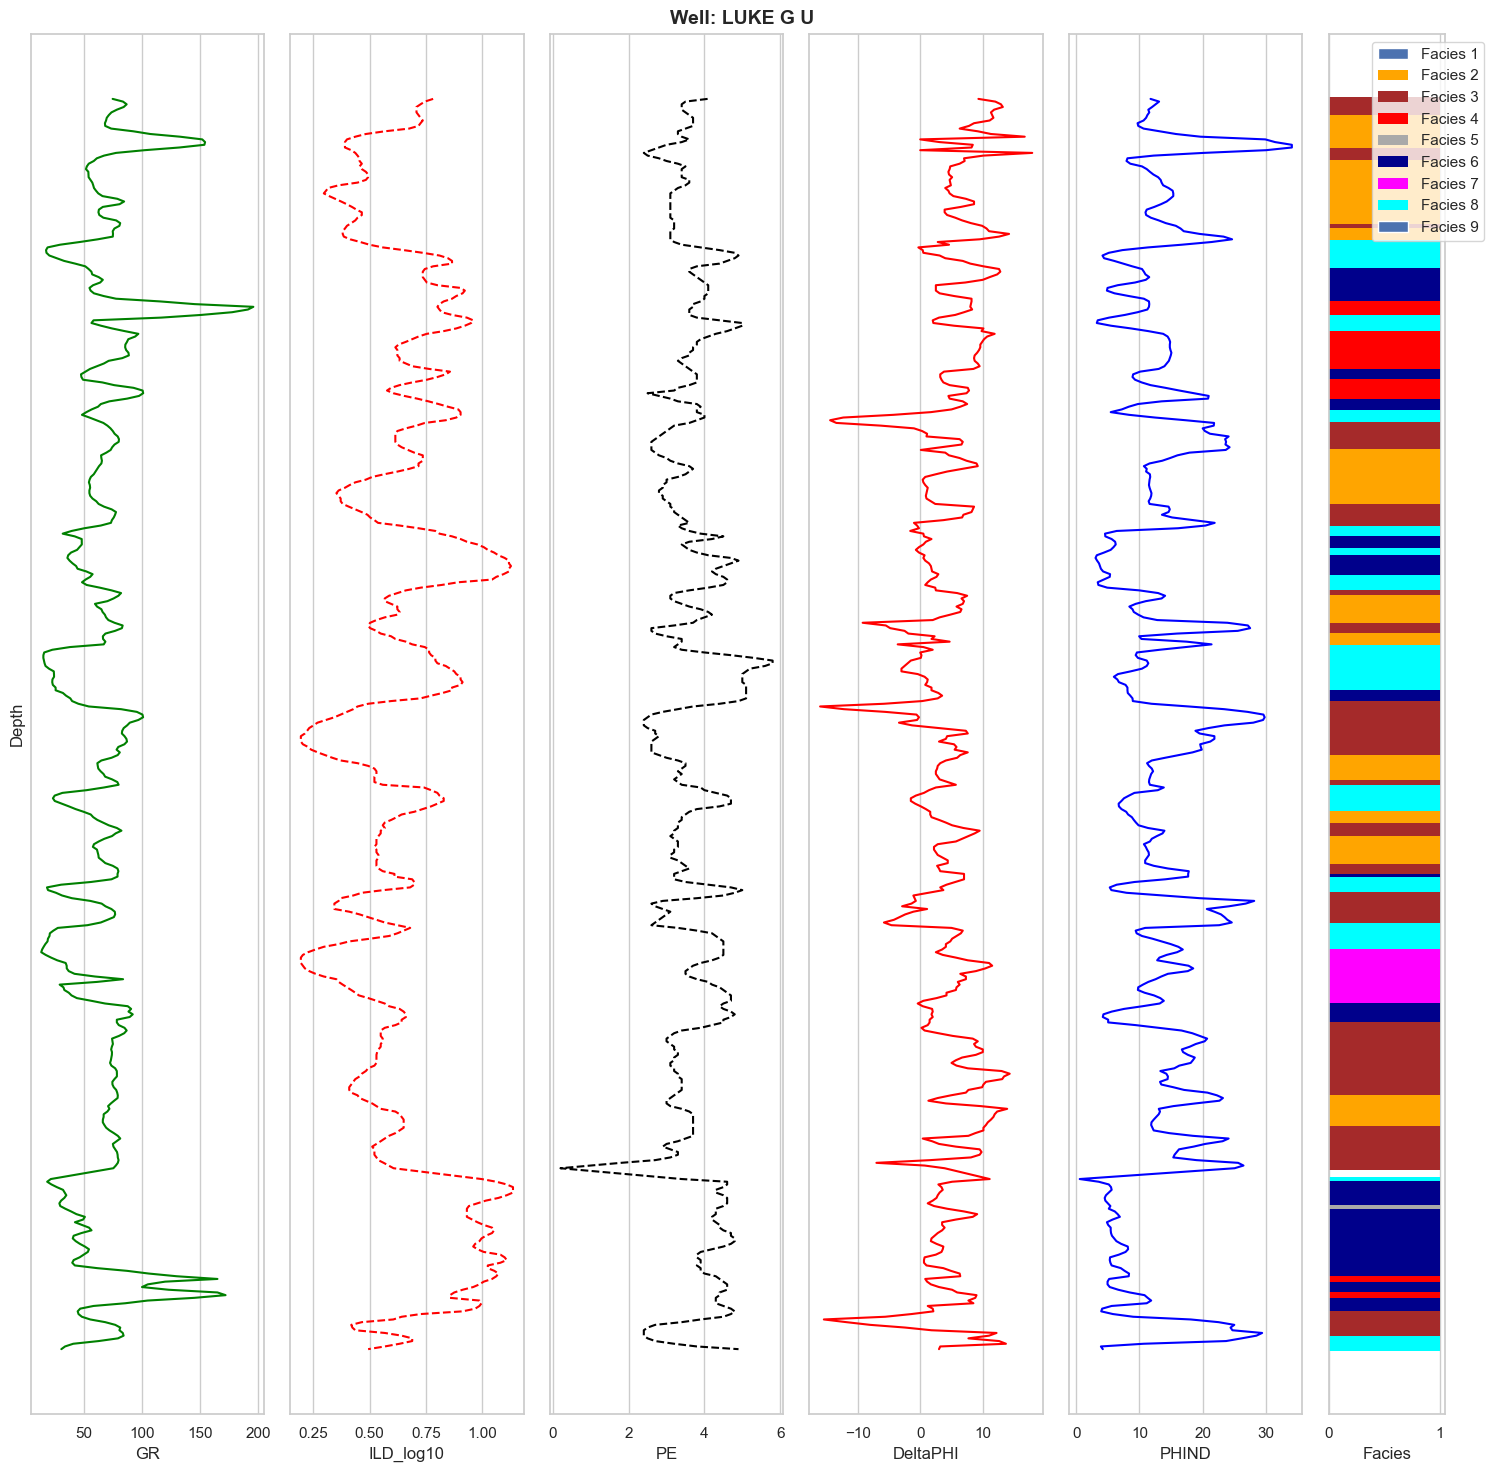

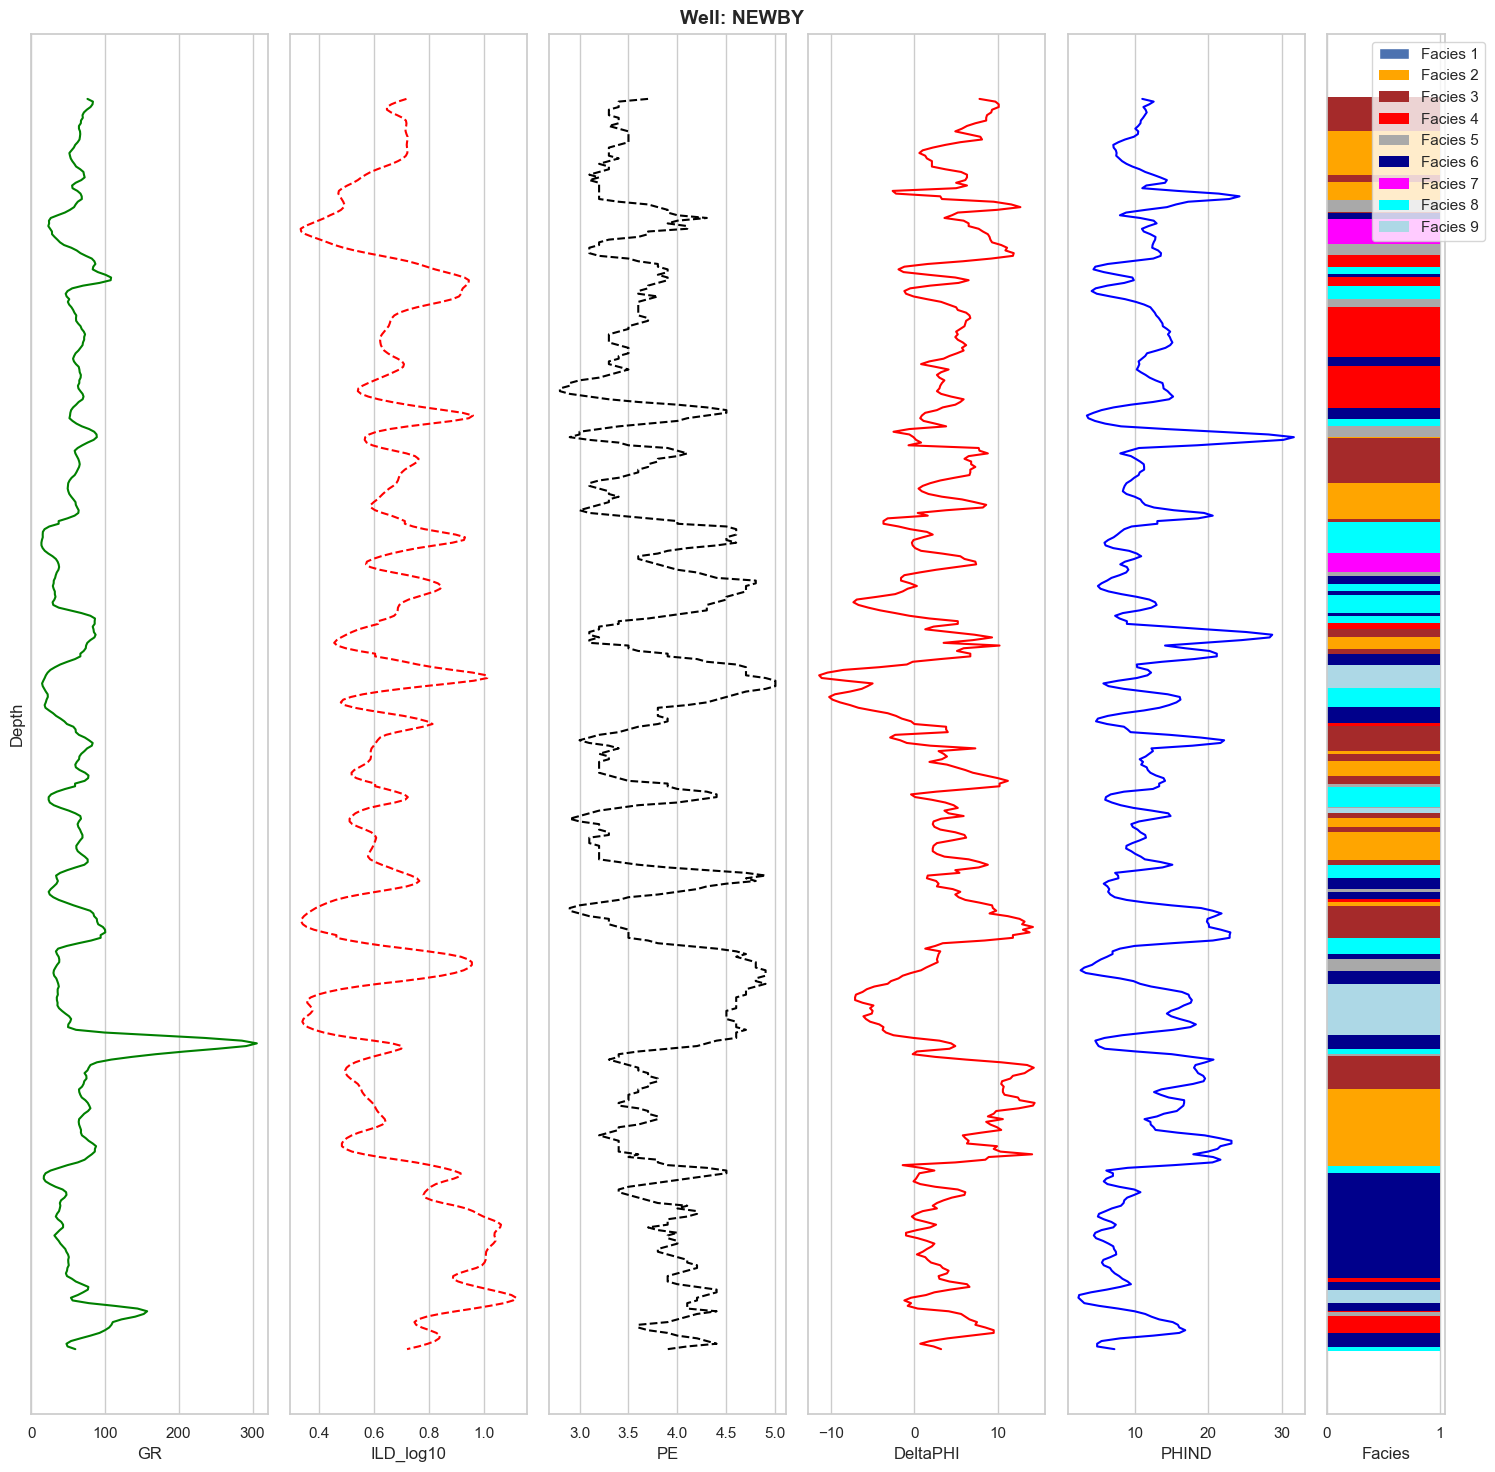

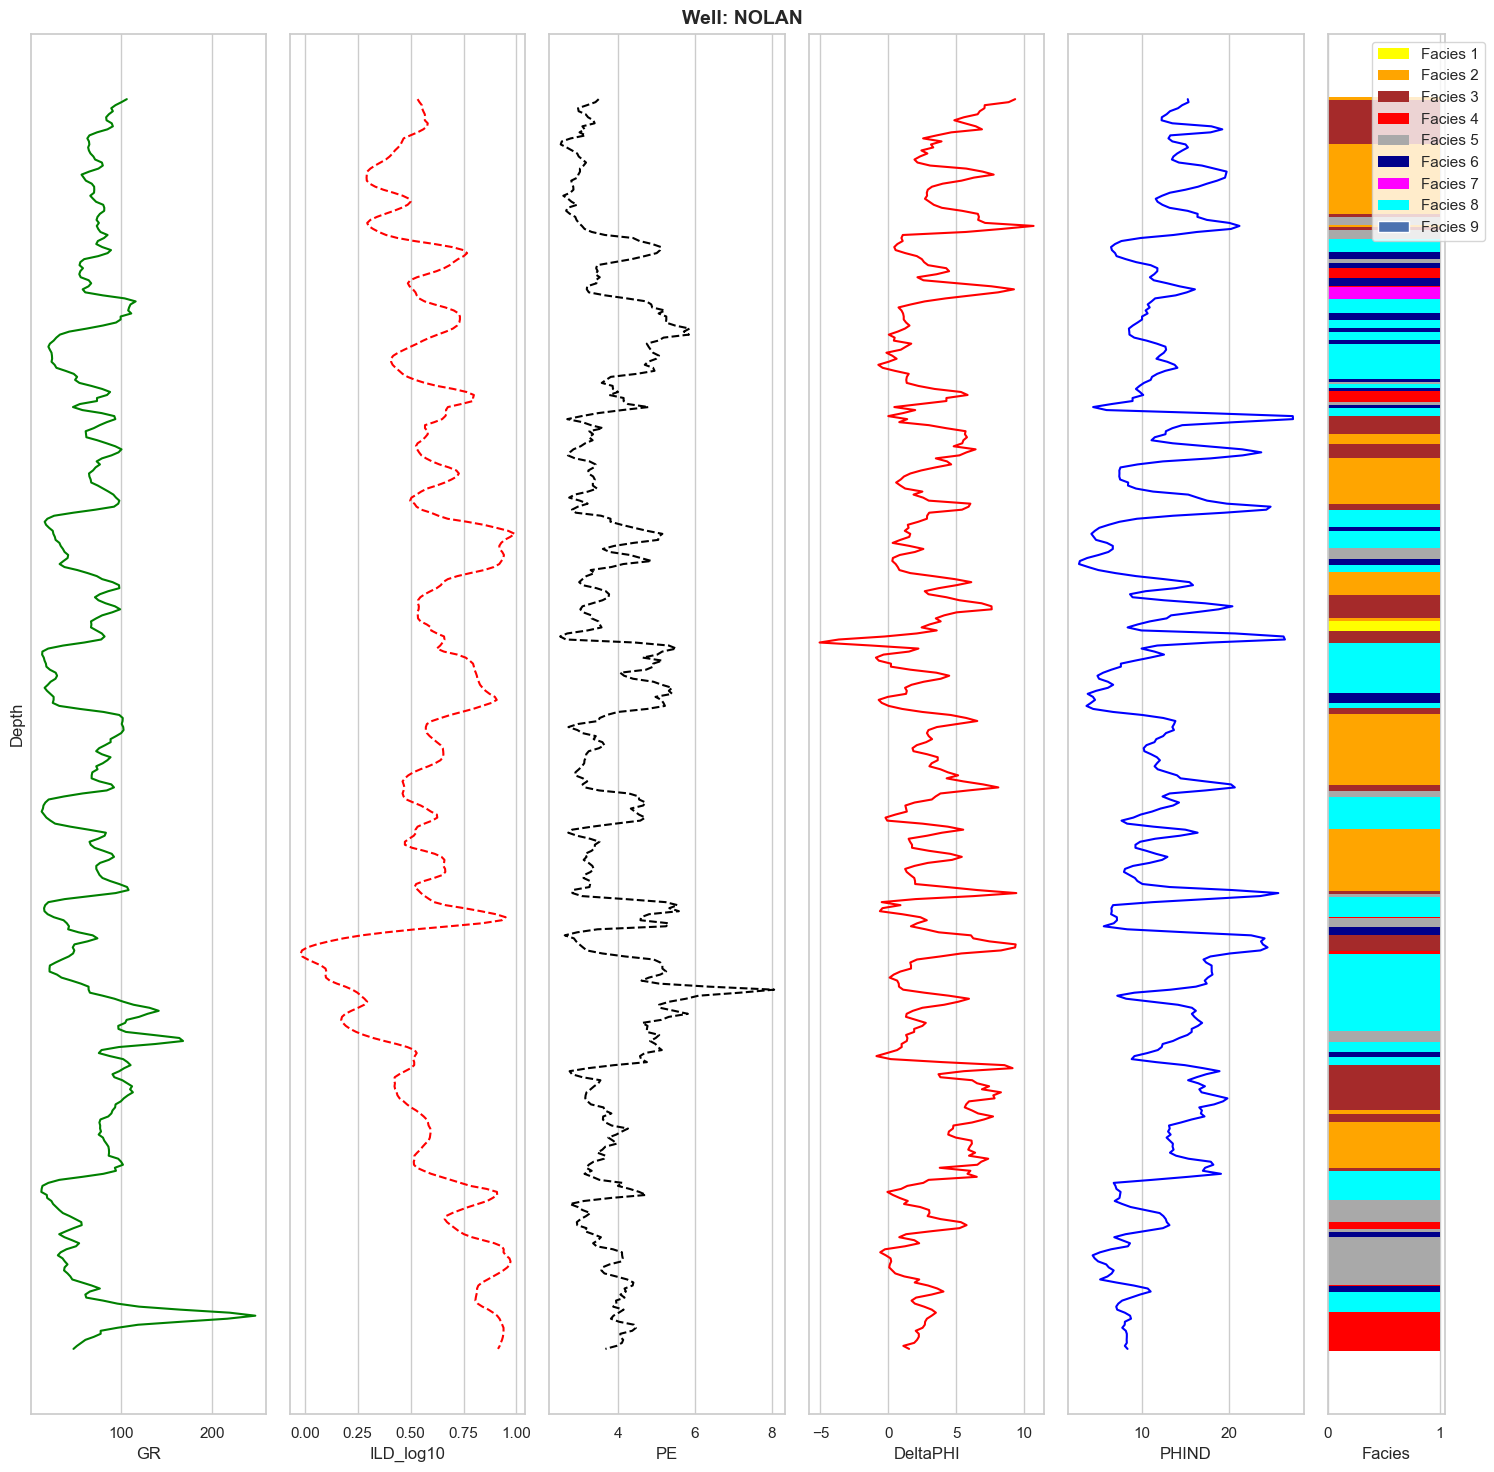

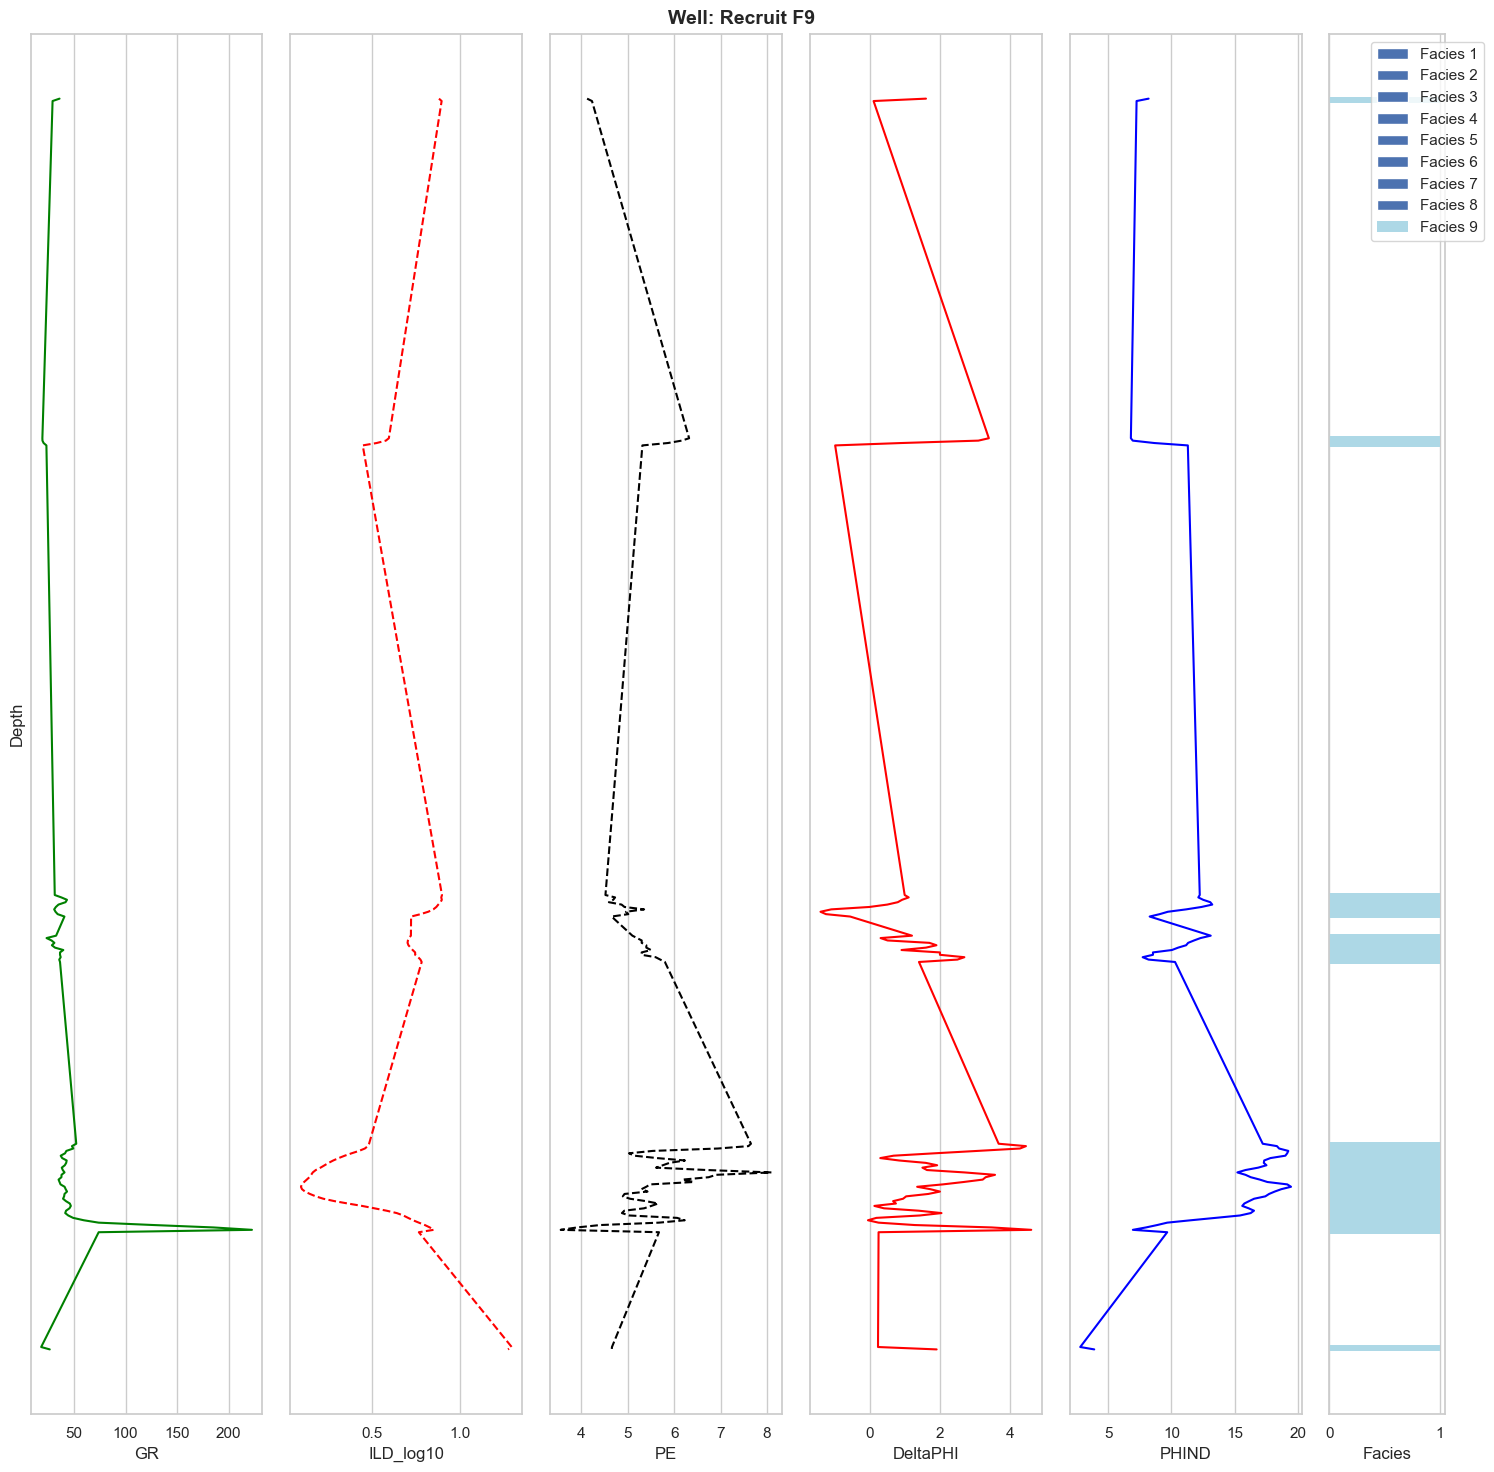

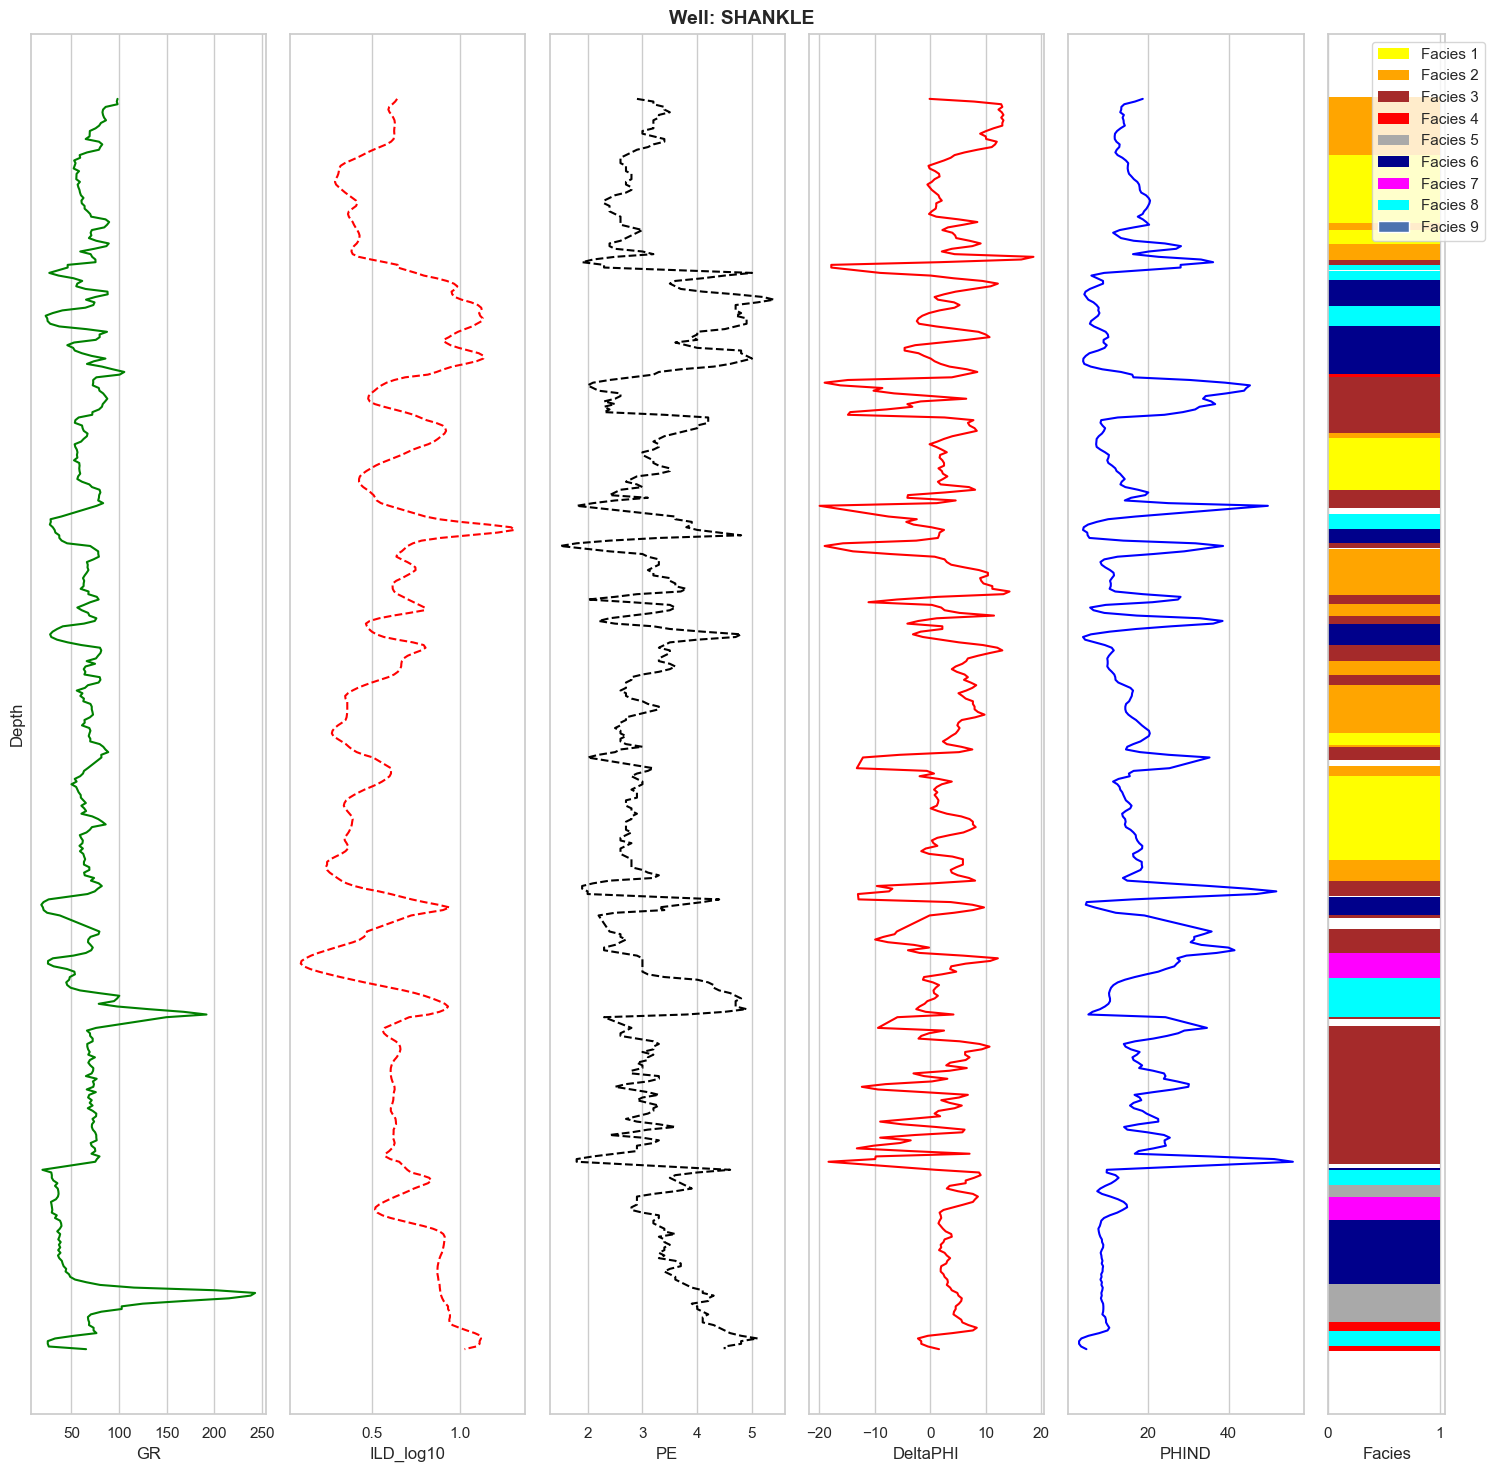

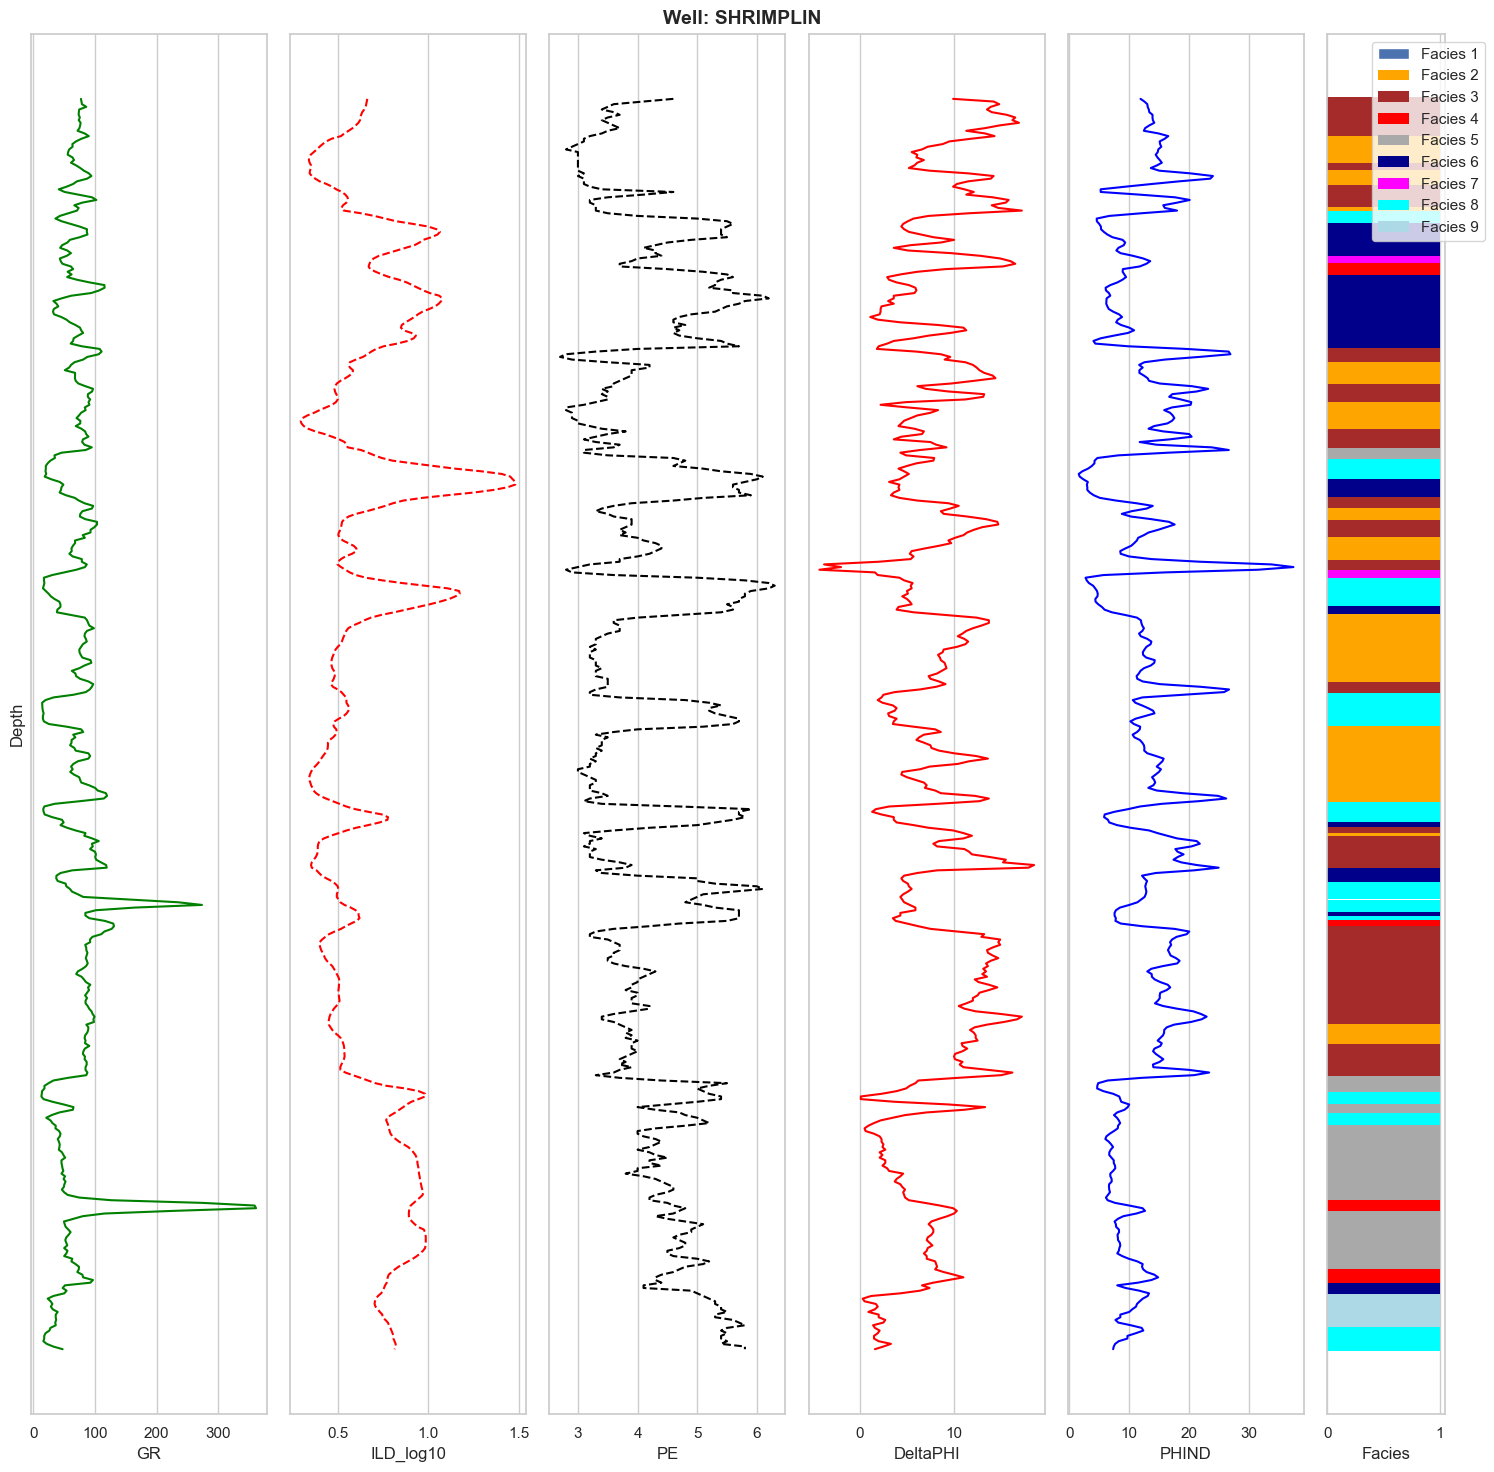

In [17]:
# Ensure Depth is sorted in ascending order
data = data.sort_values(by=["Well Name", "Depth"])

# Define the logs to be plotted
logs = ["GR", "ILD_log10", "PE", "DeltaPHI", "PHIND"]  # Exclude "NM_M" and "RELPOS"
num_logs = len(logs)

# Define facies colors with more variation
#facies_colors = sns.color_palette("tab20", n_colors=data["Facies"].nunique())
facies_color_map =facies_colors #dict(zip(sorted(data["Facies"].unique()), facies_colors))

# Define line styles and colors for each log
log_styles = {
    "GR": {"color": "green", "linestyle": "-"},
    "ILD_log10": {"color": "red", "linestyle": "--"},
    "PE": {"color": "black", "linestyle": "--"},
    "DeltaPHI": {"color": "red", "linestyle": "-"},
    "PHIND": {"color": "blue", "linestyle": "-"},
}

# Get unique well names
wells = data["Well Name"].unique()

# Iterate over each well and create individual plots
for well in wells:
    well_data = data[data["Well Name"] == well]
    
    # Set up the figure and axes with increased vertical scale
    fig, axes = plt.subplots(1, num_logs + 1, figsize=(15, 15), sharey=True, gridspec_kw={'width_ratios': [1] * num_logs + [0.5]})
    fig.suptitle(f"Well: {well}", fontsize=14, fontweight='bold')
    
    # Plot each log
    for i, log in enumerate(logs):
        axes[i].plot(well_data[log], well_data["Depth"], label=log, **log_styles[log])
        axes[i].invert_yaxis()  # Depth increases downward
        axes[i].set_xlabel(log)
        axes[i].grid(True)
        if i == 0:
            axes[i].set_ylabel("Depth")
    
    # Add the categorical facies track
    for facies, color in facies_color_map.items():
        mask = well_data["Facies"] == facies
        axes[-1].barh(
            well_data.loc[mask, "Depth"],
            1,
            left=0,
            color=color,
            edgecolor="none",
            label=f"Facies {facies}"
        )
    axes[-1].set_xlabel("Facies")
    axes[-1].set_yticks([])
    axes[-1].legend(loc="upper right", bbox_to_anchor=(1.4, 1))
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [18]:
negative_ild_log10 = data[data["ILD_log10"] < 0]

# Display the filtered rows
negative_ild_log10

Facies Formation       Well Name   Depth      GR  ILD_log10  DeltaPHI  \
1421       1     A1 SH  CROSS H CATTLE  2593.5  58.413  -0.004365     2.300   
1422       1     A1 SH  CROSS H CATTLE  2594.0  60.306  -0.011441     2.200   
1423       1     A1 SH  CROSS H CATTLE  2594.5  60.198  -0.015923     2.300   
1424       1     A1 SH  CROSS H CATTLE  2595.0  56.657  -0.019088     2.800   
1425       1     A1 SH  CROSS H CATTLE  2595.5  59.459  -0.022734     2.900   
1426       1     A1 SH  CROSS H CATTLE  2596.0  59.586  -0.025949     3.100   
1427       1     A1 SH  CROSS H CATTLE  2596.5  58.077  -0.025949     3.300   
1428       1     A1 SH  CROSS H CATTLE  2597.0  59.244  -0.019088     3.400   
1429       1     A1 SH  CROSS H CATTLE  2597.5  60.552  -0.002614     3.300   
2164       3     B5 SH           NOLAN  2994.5  49.375  -0.013000     8.292   
2165       4     B5 LM           NOLAN  2995.0  48.031  -0.019000     5.381   
2166       8     B5 LM           NOLAN  2995.5  43.250  -0.012000     3.818   

       PHIND     PE  NM_M  RELPOS  
1421  20.250  2.574     1   0.434  
1422  19.900  2.571     1   0.421  
1423  19.950  2.556     1   0.408  
1424  20.100  2.552     1   0.395  
1425  20.250  2.514     1   0.382  
1426  20.450  2.508     1   0.368  
1427  20.650  2.516     1   0.355  
1428  20.500  2.581     1   0.342  
1429  20.450  2.589     1   0.329  
2164  23.544  3.191     1   0.250  
2165  20.059  3.592     1   0.125  
2166  17.813  4.191     2   1.000

##### Negative ILD values are found only in the CROSS H CATTLE well, at around 2593 TO 2597M Depth.

In [19]:
HighGH = data[data["GR"] >150]

# Display the filtered rows
HighGH

Facies Formation        Well Name   Depth       GR  ILD_log10  DeltaPHI  \
2994       3     B2 SH  CHURCHMAN BIBLE  3000.5  207.125      0.707    -0.923   
2995       3     B2 SH  CHURCHMAN BIBLE  3001.0  221.125      0.664    -9.690   
2996       3     B2 SH  CHURCHMAN BIBLE  3001.5  183.375      0.610    -9.880   
3144       9     B5 LM  CHURCHMAN BIBLE  3079.0  185.250      0.830     3.480   
3145       9     B5 LM  CHURCHMAN BIBLE  3079.5  222.500      0.852     4.614   
...      ...       ...              ...     ...      ...        ...       ...   
304        8     B5 LM        SHRIMPLIN  2945.0  164.340      0.573     5.900   
415        4      C LM        SHRIMPLIN  3000.5  274.000      0.920     6.900   
416        4      C LM        SHRIMPLIN  3001.0  358.740      0.903     8.500   
417        4      C LM        SHRIMPLIN  3001.5  361.150      0.896     9.900   
418        4      C LM        SHRIMPLIN  3002.0  227.990      0.894    10.300   

       PHIND     PE  NM_M  RELPOS  
2994  22.896  2.350     2   0.063  
2995  39.427  2.043     2   0.031  
2996  45.231  1.927     1   1.000  
3144   7.995  3.912     2   0.167  
3145   6.959  3.557     2   0.150  
...      ...    ...   ...     ...  
304    8.480  5.300     2   0.300  
415    7.650  4.500     2   0.549  
416   10.035  4.600     2   0.539  
417   12.255  4.800     2   0.529  
418   12.670  4.700     2   0.520  

[62 rows x 11 columns]

In [20]:
A1_SH = data[data["Formation"] =='A1 SH']

# Display the filtered rows
A1_SH

Facies Formation        Well Name   Depth       GR  ILD_log10  DeltaPHI  \
2828       3     A1 SH  CHURCHMAN BIBLE  2917.5   63.500      0.705     4.916   
2829       3     A1 SH  CHURCHMAN BIBLE  2918.0   80.875      0.709     7.514   
2830       3     A1 SH  CHURCHMAN BIBLE  2918.5   87.813      0.700     7.785   
2831       3     A1 SH  CHURCHMAN BIBLE  2919.0   86.750      0.685     7.547   
2832       3     A1 SH  CHURCHMAN BIBLE  2919.5   79.438      0.669     5.912   
...      ...       ...              ...     ...      ...        ...       ...   
38         3     A1 SH        SHRIMPLIN  2812.0  102.350      0.558    15.800   
39         3     A1 SH        SHRIMPLIN  2812.5   79.700      0.549    15.500   
40         3     A1 SH        SHRIMPLIN  2813.0   66.690      0.530    14.000   
41         2     A1 SH        SHRIMPLIN  2813.5   73.680      0.521    14.700   
42         2     A1 SH        SHRIMPLIN  2814.0   71.050      0.535    17.200   

       PHIND     PE  NM_M  RELPOS  
2828  12.174  3.162     1   1.000  
2829  13.286  2.932     1   0.950  
2830  13.212  2.953     1   0.900  
2831  13.547  3.420     1   0.850  
2832  12.252  3.324     1   0.800  
...      ...    ...   ...     ...  
38    20.145  3.200     1   0.106  
39    18.070  3.200     1   0.085  
40    15.720  3.300     1   0.064  
41    15.980  3.300     1   0.043  
42    18.020  3.300     1   0.021  

[336 rows x 11 columns]

In [21]:
# Group by Formation and get unique Facies per Formation
facies_per_formation = data.groupby("Formation")["Facies"].unique()

# Print the unique facies for each formation
for formation, facies in facies_per_formation.items():
    print(f"Formation: {formation}, Unique Facies: {list(facies)}")

Formation: A1 LM, Unique Facies: [8, 6, 5, 3, 4, 7, 9]
Formation: A1 SH, Unique Facies: [3, 2, 1, 8, 5]
Formation: B1 LM, Unique Facies: [5, 7, 8, 6, 4]
Formation: B1 SH, Unique Facies: [3, 2, 1, 4]
Formation: B2 LM, Unique Facies: [5, 8, 9, 6, 7, 4]
Formation: B2 SH, Unique Facies: [3, 7, 1, 2, 5, 4]
Formation: B3 LM, Unique Facies: [8, 6, 7, 5, 9]
Formation: B3 SH, Unique Facies: [3, 2, 1]
Formation: B4 LM, Unique Facies: [8, 6, 4, 5]
Formation: B4 SH, Unique Facies: [2, 3, 1]
Formation: B5 LM, Unique Facies: [8, 7, 9, 6, 5, 4]
Formation: B5 SH, Unique Facies: [3, 2, 5]
Formation: C LM, Unique Facies: [8, 9, 5, 6, 4, 2, 3, 7]
Formation: C SH, Unique Facies: [3, 2]


In [22]:
facies_colors

{1: 'yellow',
 2: 'orange',
 3: 'brown',
 4: 'red',
 5: 'darkgrey',
 6: 'darkblue',
 7: 'magenta',
 8: 'cyan',
 9: 'lightblue'}

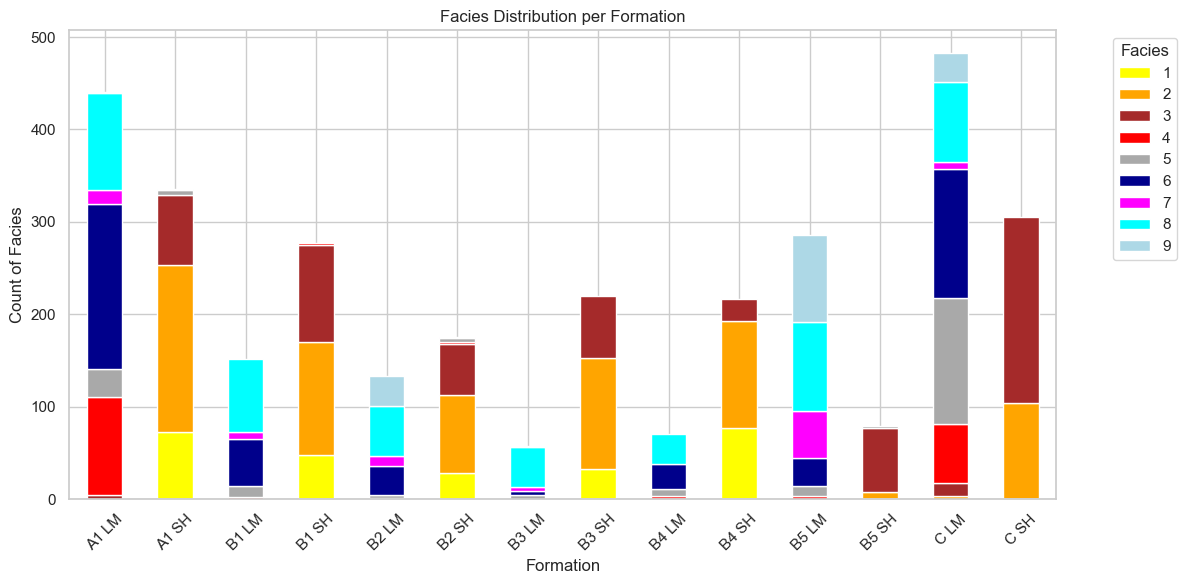

In [23]:
# Count occurrences of each facies per formation
facies_counts = data.groupby(["Formation", "Facies"]).size().unstack()

# Plot bar charts
facies_counts.plot(kind="bar", stacked=True, figsize=(12, 6), color=[facies_colors[f] for f in facies_counts.columns])
plt.xlabel("Formation")
plt.ylabel("Count of Facies")
plt.title("Facies Distribution per Formation")
plt.legend(title="Facies", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Formation: A1 LM, Unique Facies: [8, 6, 5, 3, 4, 7, 9]
#Formation: A1 SH, Unique Facies: [3, 2, 1, 8, 5]
#Formation: B1 LM, Unique Facies: [5, 7, 8, 6, 4]
#Formation: B1 SH, Unique Facies: [3, 2, 1, 4]
#Formation: B2 LM, Unique Facies: [5, 8, 9, 6, 7, 4]
#Formation: B2 SH, Unique Facies: [3, 7, 1, 2, 5, 4]
#Formation: B3 LM, Unique Facies: [8, 6, 7, 5, 9]
#Formation: B3 SH, Unique Facies: [3, 2, 1]
#Formation: B4 LM, Unique Facies: [8, 6, 4, 5]
#Formation: B4 SH, Unique Facies: [2, 3, 1]
#Formation: B5 LM, Unique Facies: [8, 7, 9, 6, 5, 4]
#Formation: B5 SH, Unique Facies: [3, 2, 5]
#Formation: C LM, Unique Facies: [8, 9, 5, 6, 4, 2, 3, 7]
#Formation: C SH, Unique Facies: [3, 2]

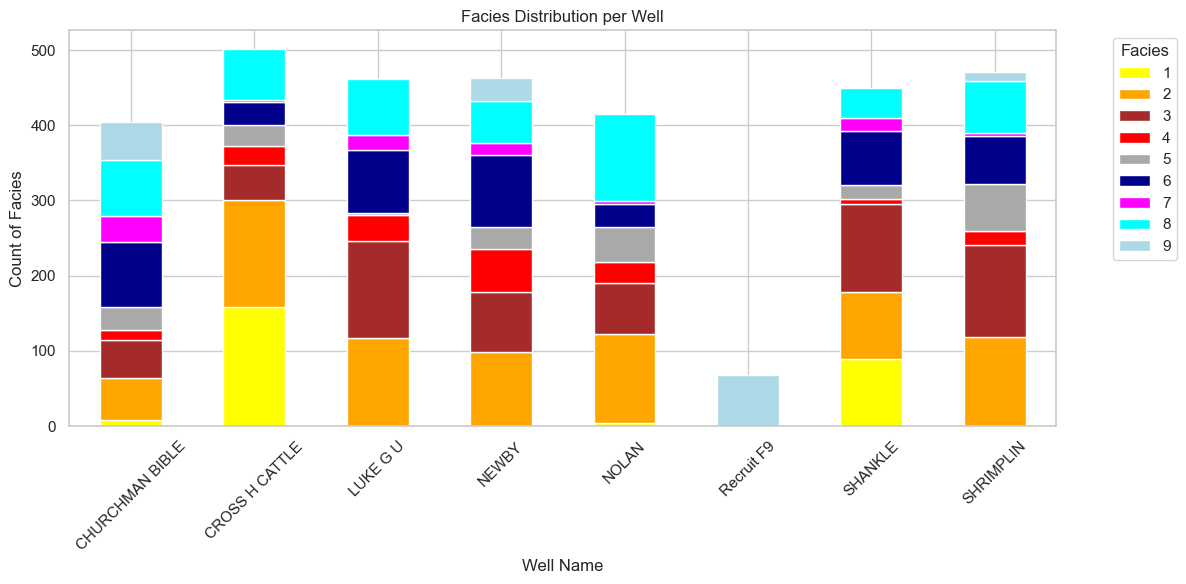

In [24]:
# Count occurrences of each facies per well
facies_counts = data.groupby(["Well Name", "Facies"]).size().unstack()

# Plot bar chart
facies_counts.plot(kind="bar", stacked=True, figsize=(12, 6), color=[facies_colors[f] for f in facies_counts.columns])
plt.xlabel("Well Name")
plt.ylabel("Count of Facies")
plt.title("Facies Distribution per Well")
plt.legend(title="Facies", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###### Facies 9 is mostly found in well Recruit F9, and also in 3 other wells

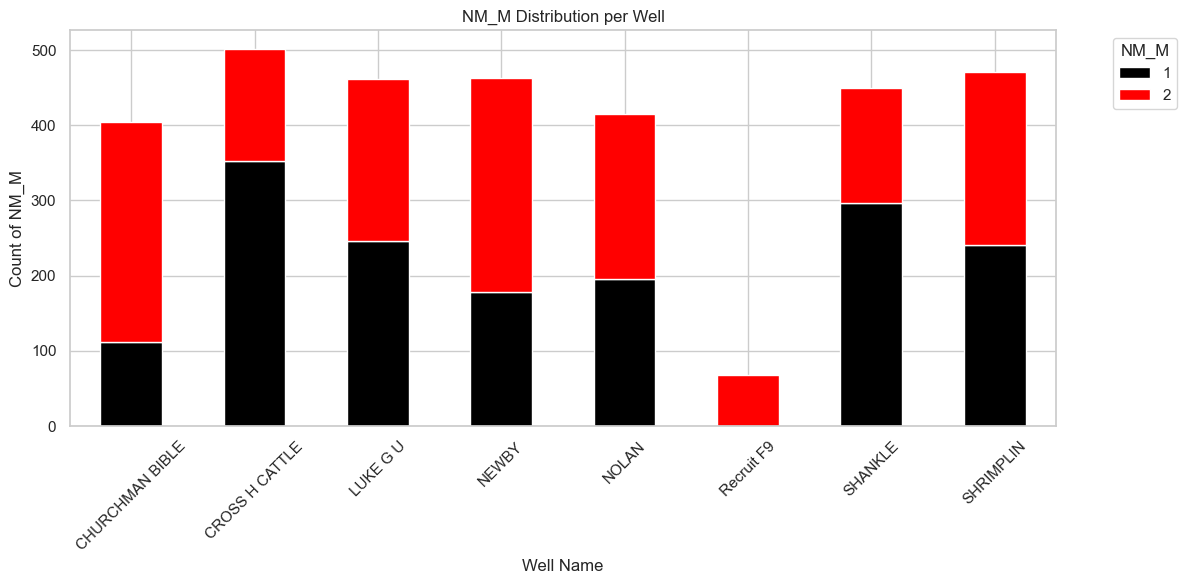

In [25]:
# Count occurrences of each NM_M category per well
nm_m_counts = data.groupby(["Well Name", "NM_M"]).size().unstack()

# Plot bar chart
nm_m_counts.plot(kind="bar", stacked=True, figsize=(12, 6), color=[Depo_env_colors[f] for f in nm_m_counts.columns])
plt.xlabel("Well Name")
plt.ylabel("Count of NM_M")
plt.title("NM_M Distribution per Well")
plt.legend(title="NM_M", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

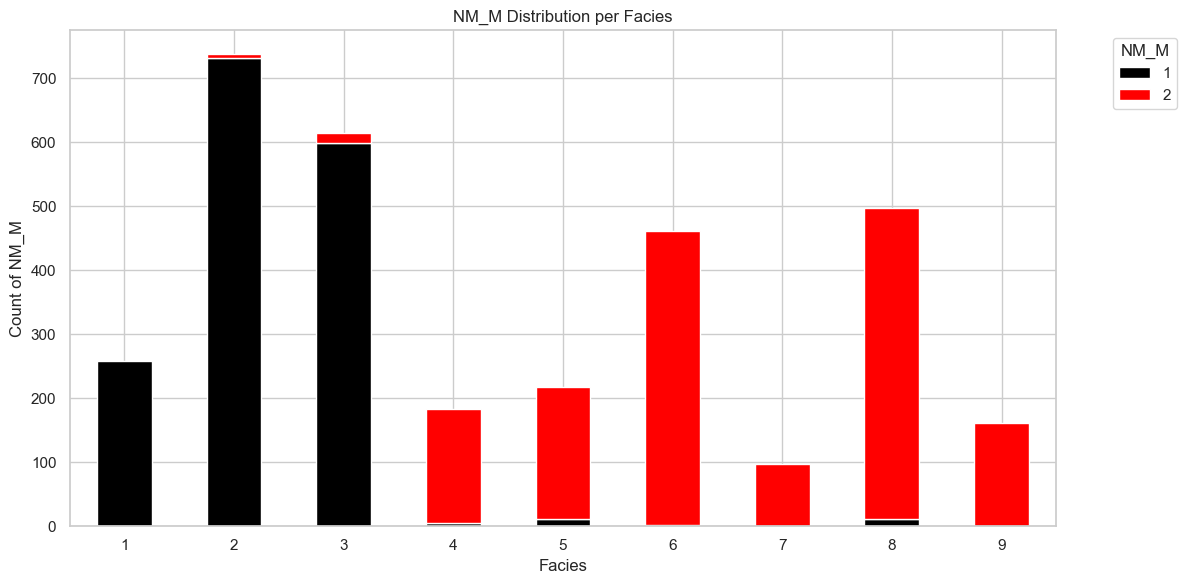

In [26]:
# Count occurrences of NM_M per Facies
nm_m_counts = data.groupby(["Facies", "NM_M"]).size().unstack()

# Plot bar chart
nm_m_counts.plot(kind="bar", stacked=True, figsize=(12, 6), color=[Depo_env_colors[f] for f in nm_m_counts.columns])
plt.xlabel("Facies")
plt.ylabel("Count of NM_M")
plt.title("NM_M Distribution per Facies")
plt.legend(title="NM_M", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
 
# We can see that Facies 1, 3 and 3 are mostly Non marine (1) while facies 4, to 7 are mostly Marine.

### Correlation matrix, by Marine-Non Marine

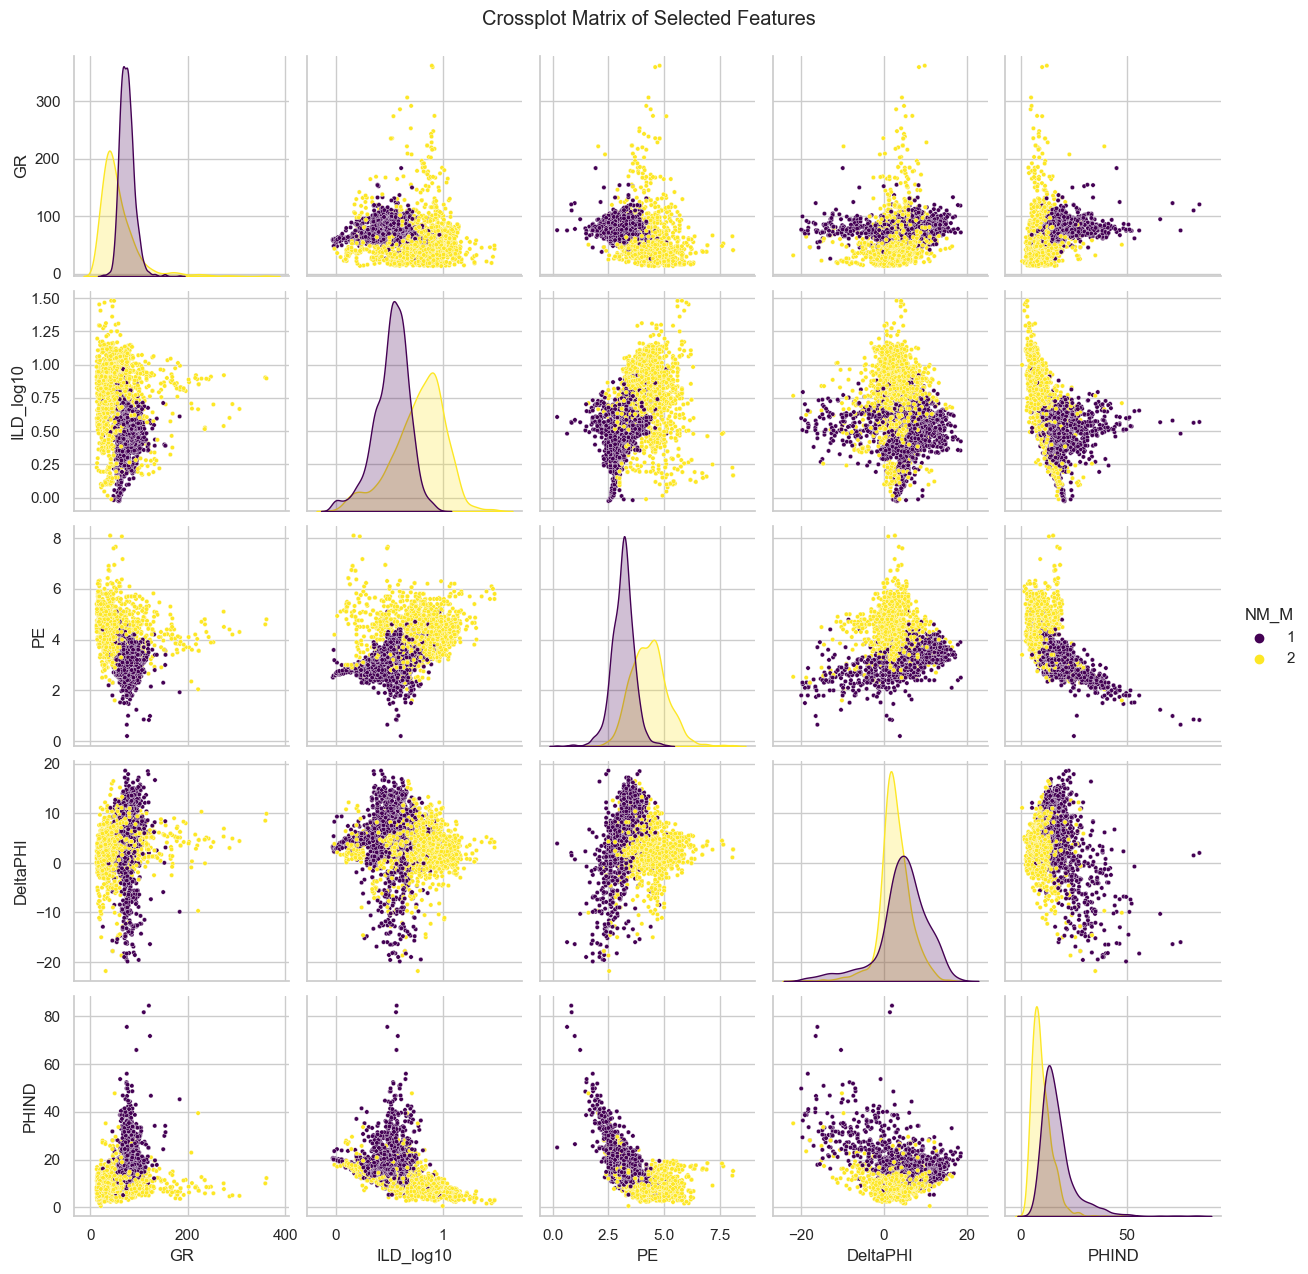

In [27]:
 grid_features = ["GR", "ILD_log10", "PE", "DeltaPHI", "PHIND"]
g = sns.pairplot(data, vars=grid_features, hue="NM_M", palette="viridis", diag_kind="kde", plot_kws={"s": 10})
g.fig.suptitle("Crossplot Matrix of Selected Features", y=1.02)
plt.show()

In [28]:
Marine = data[data["NM_M"] ==1]

# Display the filtered rows
Marine

Facies Formation        Well Name   Depth      GR  ILD_log10  DeltaPHI  \
2828       3     A1 SH  CHURCHMAN BIBLE  2917.5  63.500      0.705     4.916   
2829       3     A1 SH  CHURCHMAN BIBLE  2918.0  80.875      0.709     7.514   
2830       3     A1 SH  CHURCHMAN BIBLE  2918.5  87.813      0.700     7.785   
2831       3     A1 SH  CHURCHMAN BIBLE  2919.0  86.750      0.685     7.547   
2832       3     A1 SH  CHURCHMAN BIBLE  2919.5  79.438      0.669     5.912   
...      ...       ...              ...     ...     ...        ...       ...   
363        3      C SH        SHRIMPLIN  2974.5  86.710      0.521    10.600   
364        3      C SH        SHRIMPLIN  2975.0  84.910      0.515    11.000   
365        3      C SH        SHRIMPLIN  2975.5  84.750      0.516    13.600   
366        3      C SH        SHRIMPLIN  2976.0  87.880      0.543    16.200   
367        3      C SH        SHRIMPLIN  2976.5  86.060      0.584    15.000   

       PHIND     PE  NM_M  RELPOS  
2828  12.174  3.162     1   1.000  
2829  13.286  2.932     1   0.950  
2830  13.212  2.953     1   0.900  
2831  13.547  3.420     1   0.850  
2832  12.252  3.324     1   0.800  
...      ...    ...   ...     ...  
363   13.995  3.700     1   0.088  
364   14.065  3.900     1   0.070  
365   20.000  3.700     1   0.053  
366   23.385  3.600     1   0.035  
367   20.820  3.300     1   0.018  

[1621 rows x 11 columns]

### Giving Formation a numerical value so as to include in correlation

In [29]:
data.Formation.unique()

array(['A1 SH', 'A1 LM', 'B1 SH', 'B1 LM', 'B2 SH', 'B2 LM', 'B3 SH',
       'B3 LM', 'B4 SH', 'B4 LM', 'B5 LM', 'C SH', 'C LM', 'B5 SH'],
      dtype=object)

In [30]:
# Create a mapping of unique formations to numeric values
formation_mapping = {formation: idx + 1 for idx, formation in enumerate(data["Formation"].unique())}

# Create the new column with numeric values
data["Formation_number"] = data["Formation"].map(formation_mapping)

# Display first few rows of the dataset with the new column
print(data[["Formation", "Formation_number"]].head())

# Print the mapping of formations to numbers
print("Formation Mapping:")
print(formation_mapping)

     Formation  Formation_number
2828     A1 SH                 1
2829     A1 SH                 1
2830     A1 SH                 1
2831     A1 SH                 1
2832     A1 SH                 1
Formation Mapping:
{'A1 SH': 1, 'A1 LM': 2, 'B1 SH': 3, 'B1 LM': 4, 'B2 SH': 5, 'B2 LM': 6, 'B3 SH': 7, 'B3 LM': 8, 'B4 SH': 9, 'B4 LM': 10, 'B5 LM': 11, 'C SH': 12, 'C LM': 13, 'B5 SH': 14}


In [31]:
data

Facies Formation        Well Name   Depth      GR  ILD_log10  DeltaPHI  \
2828       3     A1 SH  CHURCHMAN BIBLE  2917.5  63.500      0.705     4.916   
2829       3     A1 SH  CHURCHMAN BIBLE  2918.0  80.875      0.709     7.514   
2830       3     A1 SH  CHURCHMAN BIBLE  2918.5  87.813      0.700     7.785   
2831       3     A1 SH  CHURCHMAN BIBLE  2919.0  86.750      0.685     7.547   
2832       3     A1 SH  CHURCHMAN BIBLE  2919.5  79.438      0.669     5.912   
...      ...       ...              ...     ...     ...        ...       ...   
466        8      C LM        SHRIMPLIN  3026.0  17.920      0.808     1.500   
467        8      C LM        SHRIMPLIN  3026.5  16.510      0.814     2.000   
468        8      C LM        SHRIMPLIN  3027.0  21.940      0.820     3.300   
469        8      C LM        SHRIMPLIN  3027.5  32.540      0.821     2.500   
470        8      C LM        SHRIMPLIN  3028.0  47.700      0.814     1.600   

       PHIND     PE  NM_M  RELPOS  Formation_number  
2828  12.174  3.162     1   1.000                 1  
2829  13.286  2.932     1   0.950                 1  
2830  13.212  2.953     1   0.900                 1  
2831  13.547  3.420     1   0.850                 1  
2832  12.252  3.324     1   0.800                 1  
...      ...    ...   ...     ...               ...  
466    9.730  5.400     2   0.049                13  
467    8.275  5.500     2   0.039                13  
468    7.680  5.400     2   0.029                13  
469    7.445  5.800     2   0.020                13  
470    7.340  5.800     2   0.010                13  

[3232 rows x 12 columns]

## Dealing with outliers

### 1) Quantile method

In [32]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.1)
        Q3 = df[col].quantile(0.9)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1 * IQR
        upper_bound = Q3 + 1 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
numerical_features = ["Depth", "GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "RELPOS"]

# Remove outliers from numerical features
data_scaled = remove_outliers_iqr(data.copy(), numerical_features)

# Display dataset after removing outliers
data_scaled.describe()

Facies        Depth           GR    ILD_log10     DeltaPHI  \
count  3073.000000  3073.000000  3073.000000  3073.000000  3073.000000   
mean      4.427270  2873.278392    63.312435     0.642994     3.950055   
std       2.518938   130.162636    23.926571     0.244396     4.637091   
min       1.000000  2573.500000    13.250000    -0.025949   -12.800000   
25%       2.000000  2788.500000    45.875000     0.488127     1.311000   
50%       4.000000  2891.500000    64.950000     0.624591     3.600000   
75%       6.000000  2976.500000    78.970000     0.814000     6.600000   
max       9.000000  3122.500000   154.750000     1.480000    18.600000   

             PHIND           PE         NM_M       RELPOS  Formation_number  
count  3073.000000  3073.000000  3073.000000  3073.000000       3073.000000  
mean     12.764837     3.754337     1.501139     0.522757          7.073218  
std       5.996698     0.842770     0.500080     0.283476          4.470335  
min       0.550000     1.000000     1.000000     0.010000          1.000000  
25%       8.300000     3.145000     1.000000     0.281000          2.000000  
50%      11.950000     3.586000     2.000000     0.526000          7.000000  
75%      16.106000     4.300000     2.000000     0.767000         12.000000  
max      35.770000     6.941000     2.000000     1.000000         14.000000

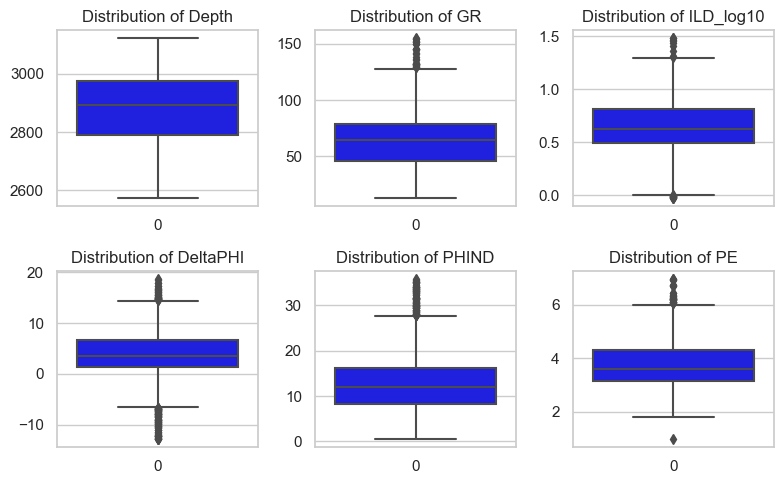

In [33]:
numerical_features = ["Depth", "GR", "ILD_log10", "DeltaPHI", "PHIND", "PE"]
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.ravel()
for i, feature in enumerate(numerical_features):
    sns.boxplot(data_scaled[feature],  ax=axes[i], color="blue")
    axes[i].set_title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

### 2) Winzorisation method 

In [34]:
data_winz=data.copy()

# Apply winsorization (cap at 5th and 95th percentiles)
for col in numerical_features:
    data_winz[col] = winsorize(data_winz[col], limits=[0.05, 0.05]).filled(data_winz[col].median())  
    #data_winz[col] = winsorize(data_winz[col], limits=[0.05, 0.05])

# Display transformed dataset
data_winz.describe()

Facies        Depth           GR    ILD_log10     DeltaPHI  \
count  3232.000000  3232.000000  3232.000000  3232.000000  3232.000000   
mean      4.422030  2875.767481    64.115291     0.643541     3.735398   
std       2.504243   126.424173    22.604880     0.222859     4.322593   
min       1.000000  2632.500000    23.480000     0.237000    -5.600000   
25%       2.000000  2791.000000    46.918750     0.492750     1.163750   
50%       4.000000  2893.500000    65.721500     0.624437     3.500000   
75%       6.000000  2980.000000    79.626250     0.812735     6.432500   
max       9.000000  3061.500000   106.290000     1.046000    12.000000   

             PHIND           PE         NM_M       RELPOS  Formation_number  
count  3232.000000  3232.000000  3232.000000  3232.000000       3232.000000  
mean     13.086513     3.718831     1.498453     0.520287          7.172030  
std       6.087130     0.802862     0.500075     0.286792          4.474293  
min       4.800000     2.520000     1.000000     0.010000          1.000000  
25%       8.346750     3.100000     1.000000     0.273000          3.000000  
50%      12.150000     3.551500     1.000000     0.526000          7.000000  
75%      16.453750     4.300000     2.000000     0.767250         12.000000  
max      27.915000     5.391000     2.000000     1.000000         14.000000

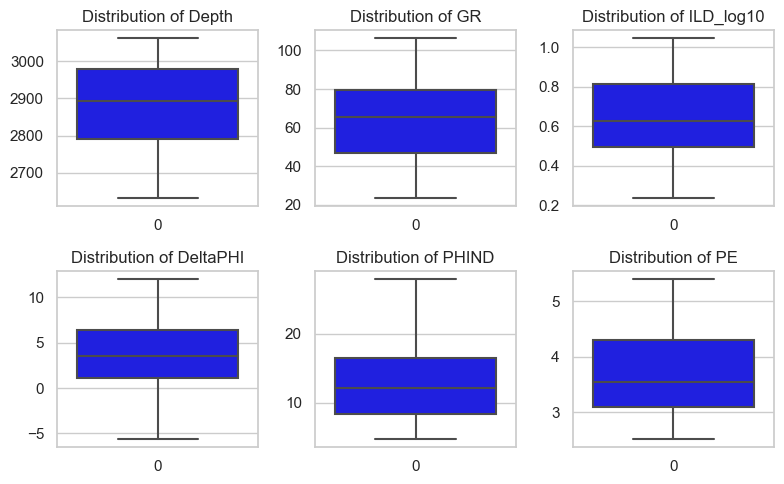

In [35]:
numerical_features = ["Depth", "GR", "ILD_log10", "DeltaPHI", "PHIND", "PE"]
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.ravel()
for i, feature in enumerate(numerical_features):
    sns.boxplot(data_winz[feature],  ax=axes[i], color="blue")
    axes[i].set_title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

### The winzorization method seems to be very strong, and removes even signals. not advisable to be used in the model

### 3) Using sklearn robust scaler

In [36]:
# pre-processing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# model selection and hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, r2_score
from sklearn.neural_network import MLPClassifier

In [37]:
scaled_data= data.copy()

# Initialize RobustScaler
scaler = RobustScaler()

# Apply RobustScaler to numerical features
scaled_data[numerical_features] = scaler.fit_transform(scaled_data[numerical_features])

# Display transformed dataset
scaled_data.describe()


Facies        Depth            GR     ILD_log10     DeltaPHI  \
count  3232.000000  3232.000000  3.232000e+03  3.232000e+03  3232.000000   
mean      4.422030    -0.093521  1.266588e-02  5.713514e-02     0.011320   
std       2.504243     0.693155  9.433563e-01  7.558007e-01     0.992446   
min       1.000000    -1.693122 -1.604265e+00 -2.032554e+00    -4.807972   
25%       2.000000    -0.542328 -5.748758e-01 -4.115411e-01    -0.443416   
50%       4.000000     0.000000  2.171657e-16  1.735266e-16     0.000000   
75%       6.000000     0.457672  4.251242e-01  5.884589e-01     0.556584   
max       9.000000     1.211640  9.032439e+00  2.673764e+00     2.865955   

             PHIND            PE         NM_M       RELPOS  Formation_number  
count  3232.000000  3.232000e+03  3232.000000  3232.000000       3232.000000  
mean      0.164452  1.445949e-01     1.498453     0.520287          7.172030  
std       0.949671  7.467935e-01     0.500075     0.286792          4.474293  
min      -1.430862 -2.792917e+00     1.000000     0.010000          1.000000  
25%      -0.469132 -3.762500e-01     1.000000     0.273000          3.000000  
50%       0.000000  1.850191e-16     1.000000     0.526000          7.000000  
75%       0.530868  6.237500e-01     2.000000     0.767250         12.000000  
max       8.912051  3.785417e+00     2.000000     1.000000         14.000000

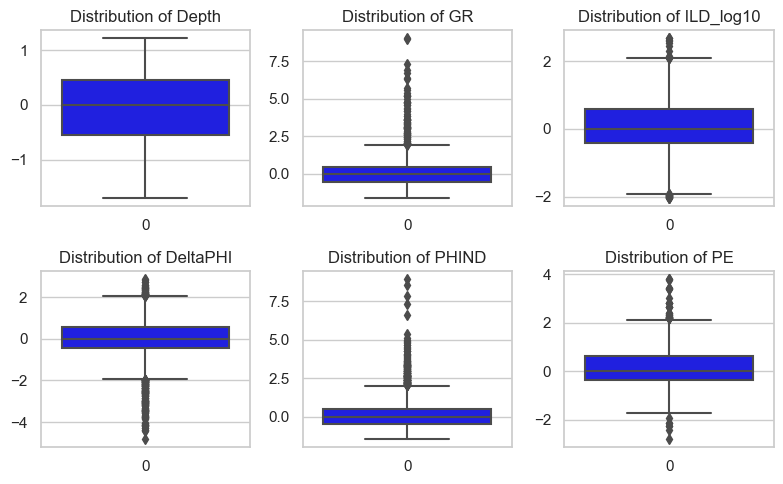

In [38]:
numerical_features = ["Depth", "GR", "ILD_log10", "DeltaPHI", "PHIND", "PE"]
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.ravel()
for i, feature in enumerate(numerical_features):
    sns.boxplot(scaled_data[feature],  ax=axes[i], color="blue")
    axes[i].set_title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

#### Robust scalar is good, but it does not remove outliers. It rather scales the data only. this should be used only for SVM where standardisation is required. However, it should be run on data where outliers have already been removed using the Quantile method.

## Spliting raw data into train and test dataset
 The first method of dataset spliting involves splitting combined data from all wells in an 80:20 ratio, using 80% for training and 20% for testing. Here there was not data left for model deployment.

In [39]:
raw_data=data.copy()

# Define features and target variable
features = ["GR", "ILD_log10", "PE", "PHIND", "Depth", 'NM_M']  # Adjust based on your dataset
target = "Facies"  # Change to the actual target column

# Split data into X (features) and y (target)
X_raw = raw_data[features]
y_raw = raw_data[target]

# Split into training (80%) and testing (20%) sets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw)

# Display the shapes of the splits
print(f"Training set: {X_train_raw.shape}, Testing set: {X_test_raw.shape}")


Training set: (2585, 6), Testing set: (647, 6)


# Random Forest method

### Finding the best hyperparameters (tunning)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Model Accuracy for unscaled data: 0.77


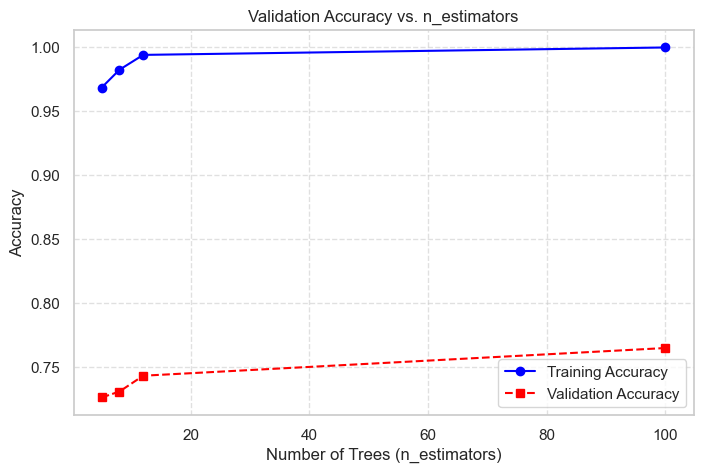

In [40]:
# Define features and target variable
features = ["GR", "ILD_log10", "PE", "DeltaPHI", "PHIND", "NM_M"]  # Selected features
target = "Facies"  # Target variable

# Define hyperparameter grid
param_grid = {
    "n_estimators": [5, 8, 12, 100],         # Number of trees
    "max_depth": [None, 5, 10, 15],       # Depth of trees
    "min_samples_split": [2, 5, 10],       # Minimum samples to split a node
    "min_samples_leaf": [1, 2, 4]          # Minimum samples in a leaf node
}

# Perform GridSearchCV to find the best parameters
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train_raw, y_train_raw)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model using the best parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_raw, y_train_raw)

# Evaluate model
y_pred_raw = best_rf.predict(X_test_raw)
accuracy = accuracy_score(y_test_raw, y_pred_raw)
print(f"Best Model Accuracy for unscaled data: {accuracy:.2f}")

# Plot Accuracy vs n_estimators
n_estimators = [5, 8, 12, 100]
train_accuracy, val_accuracy = [], []

for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train_raw, y_train_raw)
    train_accuracy.append(rf.score(X_train_raw, y_train_raw))  # Training accuracy
    val_accuracy.append(rf.score(X_test_raw, y_test_raw))      # Validation accuracy

plt.figure(figsize=(8, 5))
plt.plot(n_estimators, train_accuracy, label="Training Accuracy", marker="o", linestyle="-", color="blue")
plt.plot(n_estimators, val_accuracy, label="Validation Accuracy", marker="s", linestyle="--", color="red")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy vs. n_estimators")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



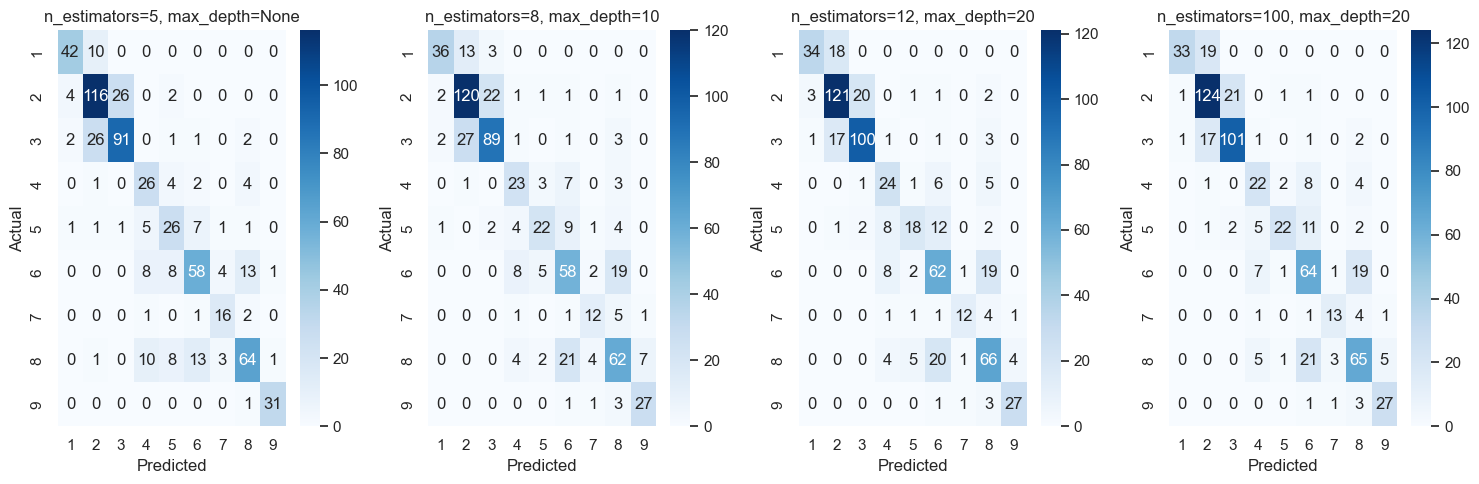

In [41]:
# Define hyperparameter grid
param_grid = [
    {"n_estimators": 5, "max_depth": None, "min_samples_split": 2, "min_samples_leaf": 1},
    {"n_estimators": 8, "max_depth": 10, "min_samples_split": 5, "min_samples_leaf": 2},
    {"n_estimators": 12, "max_depth": 20, "min_samples_split": 10, "min_samples_leaf": 4},
    {"n_estimators": 100, "max_depth": 20, "min_samples_split": 10, "min_samples_leaf": 4},
]

# Plot confusion matrices for each set of hyperparameters
fig, axes = plt.subplots(1, len(param_grid), figsize=(15, 5))

for i, params in enumerate(param_grid):
    rf = RandomForestClassifier(**params, random_state=42)
    rf.fit(X_train_raw, y_train_raw)
    y_pred_raw = rf.predict(X_test_raw)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test_raw, y_pred_raw)
    
    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"n_estimators={params['n_estimators']}, max_depth={params['max_depth']}")
    axes[i].set_xticklabels(range(1, 10))  
    axes[i].set_yticklabels(range(1, 10))
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [42]:
accuracy = accuracy_score(y_test_raw, y_pred_raw)
f1 = f1_score(y_test_raw, y_pred_raw, average='weighted')  # Weighted for imbalanced classes
r2 = r2_score(y_test_raw, y_pred_raw)

# Display results
print(f"Accuracy Score with unscaled data: {accuracy:.4f}")
print(f"F1 Score with unscaled data: {f1:.4f}")
print(f"Out of sample R² Score with unscaled data: {r2:.4f}")

Accuracy Score with unscaled data: 0.7280
F1 Score with unscaled data: 0.7277
Out of sample R² Score with unscaled data: 0.8470


### Running Algorithm with the best Hyperparameters

### a) Using unscaled data

In [43]:
# Initialize and train the RandomForestClassifier
rf_model_raw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_raw.fit(X_train_raw, y_train_raw)

# Make predictions
y_pred_raw = rf_model_raw.predict(X_test_raw)

# Evaluate model performance
accuracy_raw = accuracy_score(y_test_raw, y_pred_raw)
RF_report = classification_report(y_test_raw, y_pred_raw)

# Display results
print(f"Random Forest Model Accuracy for raw data: {accuracy_raw:.2f}")
print("Classification Report for raw data:\n", RF_report)

Random Forest Model Accuracy for raw data: 0.77
Classification Report for raw data:
               precision    recall  f1-score   support

           1       0.92      0.85      0.88        52
           2       0.84      0.84      0.84       148
           3       0.84      0.84      0.84       123
           4       0.56      0.68      0.61        37
           5       0.69      0.63      0.66        43
           6       0.64      0.68      0.66        92
           7       0.76      0.65      0.70        20
           8       0.70      0.66      0.68       100
           9       0.85      0.91      0.88        32

    accuracy                           0.77       647
   macro avg       0.76      0.75      0.75       647
weighted avg       0.77      0.77      0.77       647



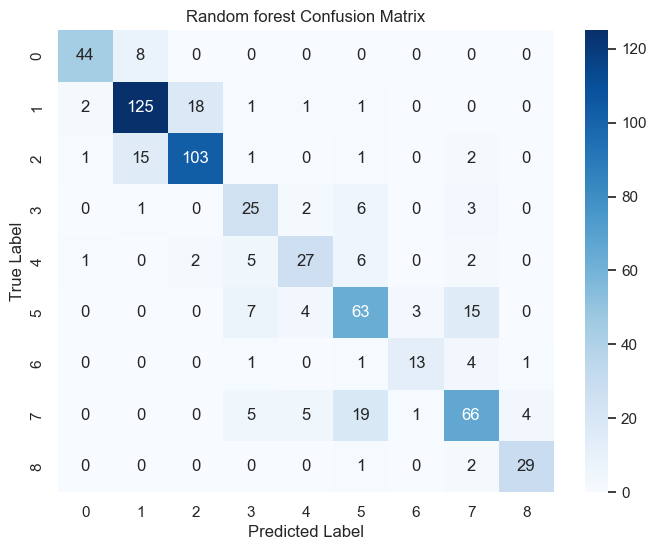

Training Wells - Accuracy on Test Set: 0.7651
              precision    recall  f1-score   support

           1       0.92      0.85      0.88        52
           2       0.84      0.84      0.84       148
           3       0.84      0.84      0.84       123
           4       0.56      0.68      0.61        37
           5       0.69      0.63      0.66        43
           6       0.64      0.68      0.66        92
           7       0.76      0.65      0.70        20
           8       0.70      0.66      0.68       100
           9       0.85      0.91      0.88        32

    accuracy                           0.77       647
   macro avg       0.76      0.75      0.75       647
weighted avg       0.77      0.77      0.77       647



In [44]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_raw, y_pred_raw)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random forest Confusion Matrix")
plt.show()

# Evaluate model
accuracy = accuracy_score(y_test_raw, y_pred_raw)
print(f"Training Wells - Accuracy on Test Set: {accuracy:.4f}")
print(classification_report(y_test_raw, y_pred_raw))

### b) Algorithm using scaled data

In [45]:
# Define features and target variable
features = ["GR", "ILD_log10", "PE", "PHIND", 'NM_M']  # Adjust based on your dataset
target = "Facies"  # Change to the actual target column

# Split data into X (features) and y (target)
X_scaled  = data_scaled [features]
y_scaled  = data_scaled [target]

# Split into training (80%) and testing (20%) sets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42, stratify=y_scaled)

# Display the shapes of the splits
print(f"Training set: {X_train_scaled.shape}, Testing set: {X_test_scaled.shape}")

Training set: (2458, 5), Testing set: (615, 5)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Model Accuracy for scaled data: 0.77


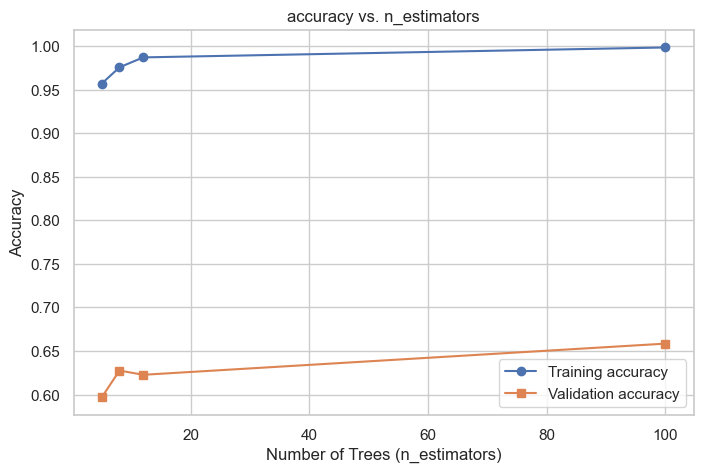

In [46]:
# Define features and target variable
features = ["GR", "ILD_log10", "PE", "DeltaPHI", "PHIND", "Depth", "NM_M"]  # Selected features
target = "Facies"  # Target variable

# Define hyperparameter grid
param_grid = {
    "n_estimators": [5, 8, 12, 100],         # Number of trees
    "max_depth": [None, 5, 10, 15],       # Depth of trees
    "min_samples_split": [2, 5, 10],       # Minimum samples to split a node
    "min_samples_leaf": [1, 2, 4]          # Minimum samples in a leaf node
}

# Perform GridSearchCV to find the best parameters
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train_scaled)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model using the best parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_scaled, y_train_scaled)

# Evaluate model
y_pred_scaled = best_rf.predict(X_test_scaled)
accuracy_scaled = accuracy_score(y_test_scaled, y_pred_scaled)
print(f"Best Model Accuracy for scaled data: {accuracy:.2f}")

# Plot validation error vs n_estimators
n_estimators = [5, 8, 12, 100]
train_accuracy_scaled, val_accuracy_scaled = [], []

for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train_scaled, y_train_scaled)
    train_accuracy_scaled.append(rf.score(X_train_scaled, y_train_scaled))  # Training error
    val_accuracy_scaled.append(rf.score(X_test_scaled, y_test_scaled))      # Validation error

plt.figure(figsize=(8, 5))
plt.plot(n_estimators, train_accuracy_scaled, label="Training accuracy", marker="o")
plt.plot(n_estimators, val_accuracy_scaled, label="Validation accuracy", marker="s")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("accuracy vs. n_estimators")
plt.legend()
plt.show()


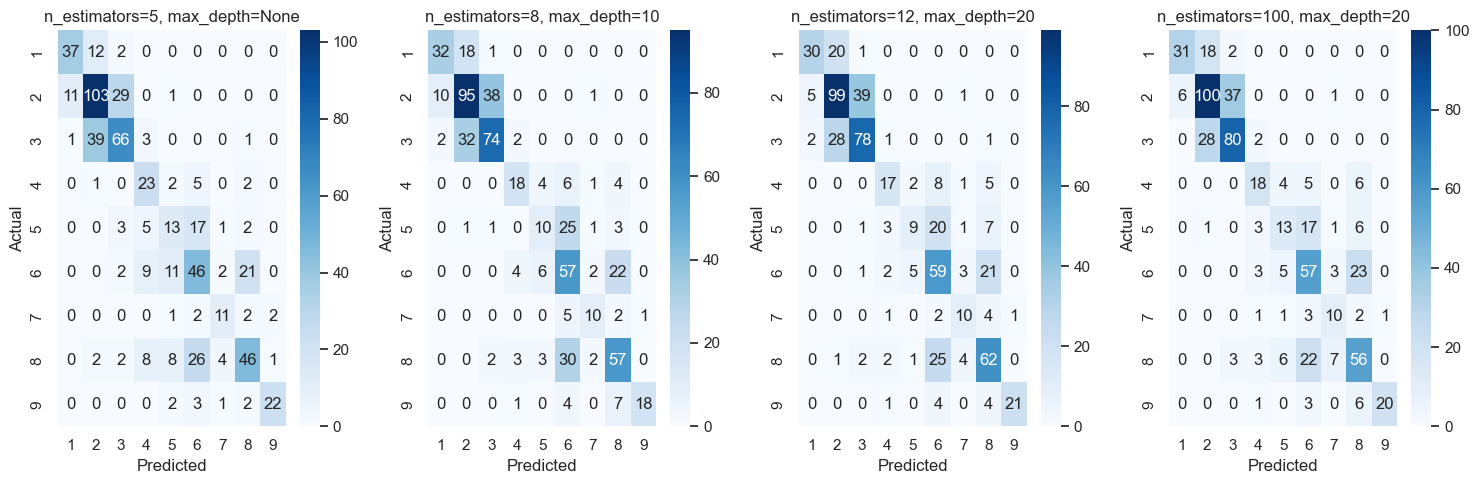

In [47]:
# Define hyperparameter grid
param_grid = [
    {"n_estimators": 5, "max_depth": None, "min_samples_split": 2, "min_samples_leaf": 1},
    {"n_estimators": 8, "max_depth": 10, "min_samples_split": 5, "min_samples_leaf": 2},
    {"n_estimators": 12, "max_depth": 20, "min_samples_split": 10, "min_samples_leaf": 4},
    {"n_estimators": 100, "max_depth": 20, "min_samples_split": 10, "min_samples_leaf": 4},
]

# Plot confusion matrices for each set of hyperparameters
fig, axes = plt.subplots(1, len(param_grid), figsize=(15, 5))

for i, params in enumerate(param_grid):
    rf = RandomForestClassifier(**params, random_state=42)
    rf.fit(X_train_scaled, y_train_scaled)
    y_pred_scaled = rf.predict(X_test_scaled)
    
    # Compute confusion matrix
    cm_scaled = confusion_matrix(y_test_scaled, y_pred_scaled)
    
    # Plot the confusion matrix
    sns.heatmap(cm_scaled, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"n_estimators={params['n_estimators']}, max_depth={params['max_depth']}")
    axes[i].set_xticklabels(range(1, 10))  
    axes[i].set_yticklabels(range(1, 10))
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [48]:
accuracy_scaled = accuracy_score(y_test_scaled, y_pred_scaled)
f1_scaled = f1_score(y_test_scaled, y_pred_scaled, average='weighted')  # Weighted for imbalanced classes


# Display results
print(f"Accuracy Score with unscaled data: {accuracy_scaled:.4f}")
print(f"F1 Score with unscaled data: {f1_scaled:.4f}")


Accuracy Score with unscaled data: 0.6260
F1 Score with unscaled data: 0.6259


In [49]:
# Initialize data to Dicts of series.
d = {'unscaled': pd.Series([f1, accuracy],
                      index=['F1 Score', 'Accuracy']),
     'scaled': pd.Series([f1_scaled, accuracy_scaled],
                      index=['F1 Score', 'Accuracy'])}

# creates Dataframe.
df1 = pd.DataFrame(d)

df1

unscaled    scaled
F1 Score   0.72769  0.625863
Accuracy   0.76507  0.626016

RF Model worked better when the data is unscaled

## ML Training by well

In this method, a well was isolated and used as a blind well, while the rest were used as training well to train the algorithm, afterwhich the model was deployed on this well, and the actual facies were evaluated against the predicted facies

In [50]:
## Creating new dataset for training and blind well:
training_split_data=data.copy()
blind_well=training_split_data[training_split_data['Well Name']=='NEWBY']
train_wells =  training_split_data[training_split_data['Well Name']!='NEWBY']

In [51]:
blind_well

Facies Formation Well Name   Depth     GR  ILD_log10  DeltaPHI  PHIND  \
2365       3     A1 SH     NEWBY  2826.0  76.34      0.719       7.8  11.00   
2366       3     A1 SH     NEWBY  2826.5  83.74      0.688       9.7  12.55   
2367       3     A1 SH     NEWBY  2827.0  83.19      0.664      10.1  11.95   
2368       3     A1 SH     NEWBY  2827.5  80.44      0.648      10.1  11.15   
2369       3     A1 SH     NEWBY  2828.0  75.42      0.648       9.3  11.45   
...      ...       ...       ...     ...    ...        ...       ...    ...   
2823       6      C LM     NEWBY  3055.0  66.94      0.838       4.0   8.00   
2824       6      C LM     NEWBY  3055.5  54.06      0.823       1.9   5.45   
2825       6      C LM     NEWBY  3056.0  47.87      0.797       0.7   4.85   
2826       6      C LM     NEWBY  3056.5  49.34      0.763       2.3   4.85   
2827       8      C LM     NEWBY  3057.0  59.88      0.721       3.2   7.20   

       PE  NM_M  RELPOS  Formation_number  
2365  3.7     1   1.000                 1  
2366  3.4     1   0.977                 1  
2367  3.4     1   0.953                 1  
2368  3.4     1   0.930                 1  
2369  3.3     1   0.907                 1  
...   ...   ...     ...               ...  
2823  4.2     2   0.292                13  
2824  4.3     2   0.281                13  
2825  4.4     2   0.270                13  
2826  4.1     2   0.258                13  
2827  3.9     2   0.247                13  

[463 rows x 12 columns]

### Running RF algorithm with best hyperparameters on the training well, and predicting on the blind well

In [52]:
# Define features and target variable
features = ["GR", "ILD_log10", "PE", "DeltaPHI", "PHIND"]  # Select features
target = "Facies"


# Prepare train and test data
X_train, X_test, y_train, y_test = train_test_split(
    train_wells[features], train_wells[target], test_size=0.3, random_state=42, stratify=train_wells[target]
)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_test_pred = rf_model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Wells - Accuracy on Test Set: {accuracy:.4f}")
print(classification_report(y_test, y_test_pred))

# Predict facies for the blind well
blind_well_predictions = rf_model.predict(blind_well[features])
blind_well["Predicted_Facies"] = blind_well_predictions  # Add predictions to dataset


Training Wells - Accuracy on Test Set: 0.6294
              precision    recall  f1-score   support

           1       0.85      0.58      0.69        78
           2       0.57      0.73      0.64       192
           3       0.68      0.68      0.68       160
           4       0.65      0.34      0.45        38
           5       0.61      0.30      0.40        57
           6       0.50      0.55      0.53       110
           7       0.62      0.21      0.31        24
           8       0.63      0.74      0.68       133
           9       0.88      0.90      0.89        39

    accuracy                           0.63       831
   macro avg       0.67      0.56      0.58       831
weighted avg       0.64      0.63      0.62       831



C:\Users\user\AppData\Local\Temp\ipykernel_27612\243244298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blind_well["Predicted_Facies"] = blind_well_predictions  # Add predictions to dataset


In [53]:
y_blind = blind_well['Facies']
blind_predicted=blind_well['Predicted_Facies']


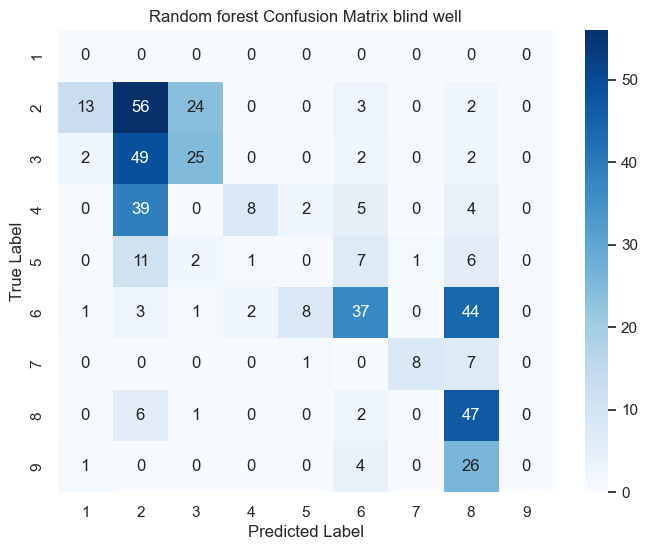

Training Wells - Accuracy on Test Set: 0.3909
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.34      0.57      0.43        98
           3       0.47      0.31      0.38        80
           4       0.73      0.14      0.23        58
           5       0.00      0.00      0.00        28
           6       0.62      0.39      0.47        96
           7       0.89      0.50      0.64        16
           8       0.34      0.84      0.48        56
           9       0.00      0.00      0.00        31

    accuracy                           0.39       463
   macro avg       0.38      0.31      0.29       463
weighted avg       0.44      0.39      0.36       463



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classif

In [54]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_blind, blind_predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random forest Confusion Matrix blind well")
plt.show()

# Evaluate model
accuracy = accuracy_score(y_blind, blind_predicted)
print(f"Training Wells - Accuracy on Test Set: {accuracy:.4f}")
print(classification_report(y_blind, blind_predicted))

### Plotting the Logs with Actual and predicted facies from Random forest

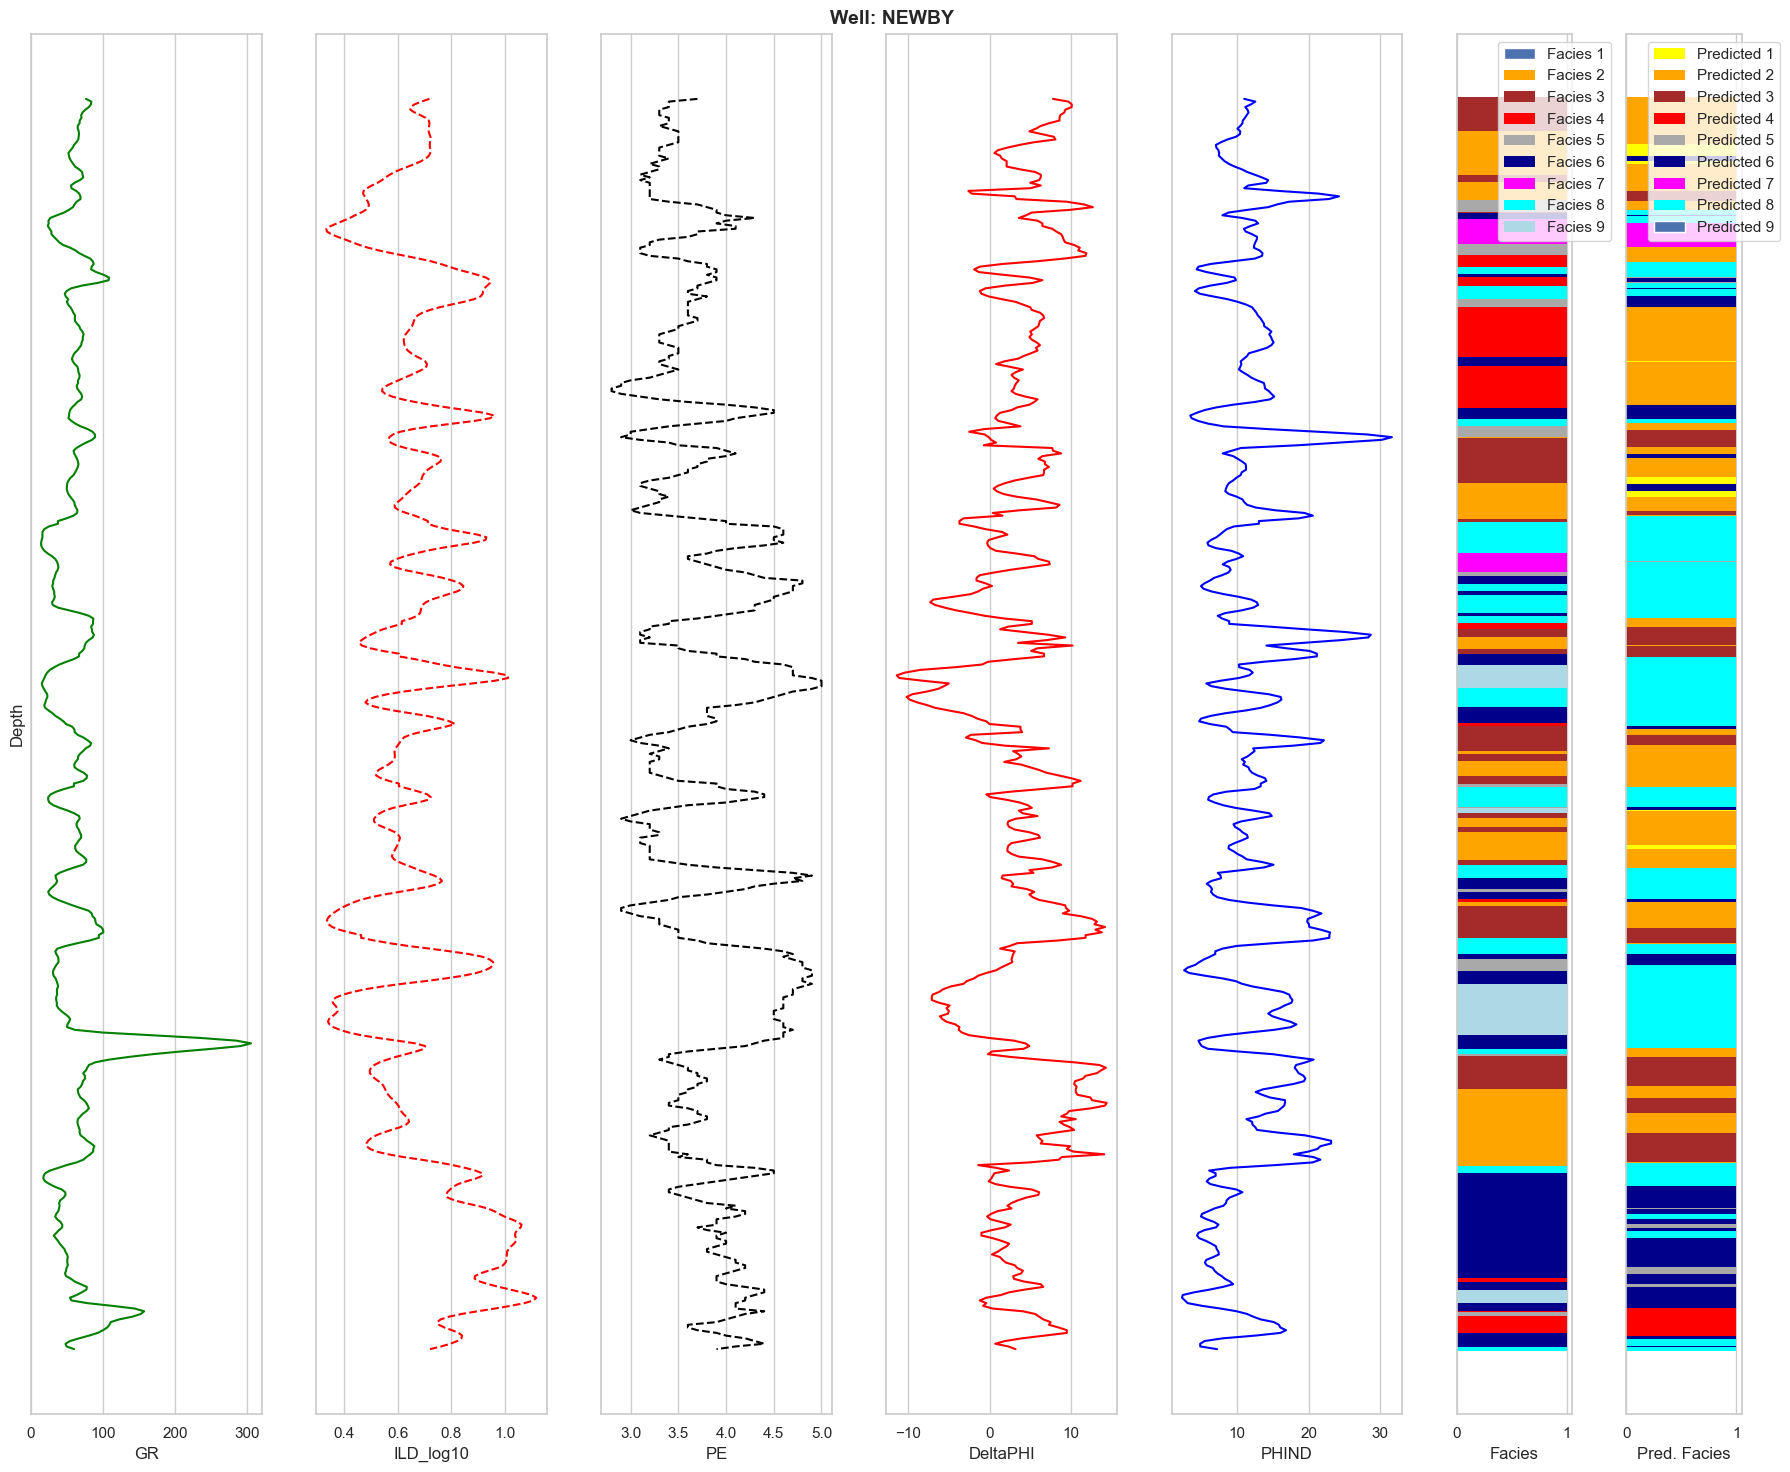

In [55]:

# Ensure Depth is sorted in ascending order
data = data.sort_values(by=["Well Name", "Depth"])

# Define the logs to be plotted
logs = ["GR", "ILD_log10", "PE", "DeltaPHI", "PHIND"]  # Exclude "NM_M" and "RELPOS"
num_logs = len(logs)

# Define facies colors with more variation
facies_color_map = facies_colors  # Assuming facies_colors is predefined

# Define line styles and colors for each log
log_styles = {
    "GR": {"color": "green", "linestyle": "-"},
    "ILD_log10": {"color": "red", "linestyle": "--"},
    "PE": {"color": "black", "linestyle": "--"},
    "DeltaPHI": {"color": "red", "linestyle": "-"},
    "PHIND": {"color": "blue", "linestyle": "-"},
}

# Get unique well names
wells = blind_well["Well Name"].unique()

# Iterate over each well and create individual plots
for well in wells:
    well_data = blind_well[blind_well["Well Name"] == well]
    
    # Set up the figure and axes with increased vertical scale
    fig, axes = plt.subplots(1, num_logs + 2, figsize=(18, 15), sharey=True, gridspec_kw={'width_ratios': [1] * num_logs + [0.5, 0.5]})
    fig.suptitle(f"Well: {well}", fontsize=14, fontweight='bold')
    
    # Plot each log
    for i, log in enumerate(logs):
        axes[i].plot(well_data[log], well_data["Depth"], label=log, **log_styles[log])
        axes[i].invert_yaxis()  # Depth increases downward
        axes[i].set_xlabel(log)
        axes[i].grid(True)
        if i == 0:
            axes[i].set_ylabel("Depth")
    
    # Add the actual facies track
    for facies, color in facies_color_map.items():
        mask = well_data["Facies"] == facies
        axes[-2].barh(
            well_data.loc[mask, "Depth"],
            1,
            left=0,
            color=color,
            edgecolor="none",
            label=f"Facies {facies}"
        )
    axes[-2].set_xlabel("Facies")
    axes[-2].set_yticks([])
    axes[-2].legend(loc="upper right", bbox_to_anchor=(1.4, 1))
    
    # Add the predicted facies track
    for facies, color in facies_color_map.items():
        mask = well_data["Predicted_Facies"] == facies
        axes[-1].barh(
            well_data.loc[mask, "Depth"],
            1,
            left=0,
            color=color,
            edgecolor="none",
            #linestyle='dotted',
            label=f"Predicted {facies}"
        )
    axes[-1].set_xlabel("Pred. Facies")
    axes[-1].set_yticks([])
    axes[-1].legend(loc="upper right", bbox_to_anchor=(1.4, 1))
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


### Finding feature importance

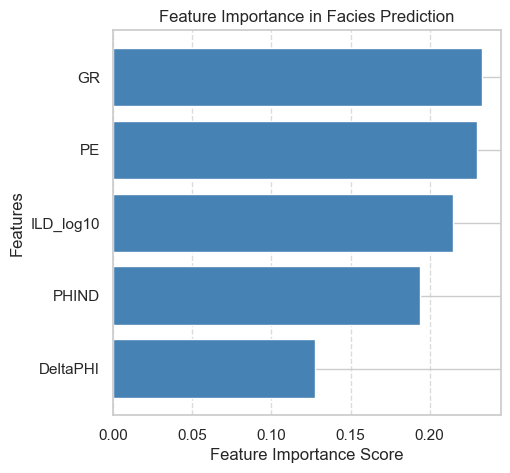

In [56]:
import numpy as np
# Get feature importance scores
feature_importances = rf_model.feature_importances_

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = [features[i] for i in sorted_indices]
sorted_importance = feature_importances[sorted_indices]

# Plot Feature Importance
plt.figure(figsize=(5, 5))
plt.barh(sorted_features[::-1], sorted_importance[::-1], color="steelblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Facies Prediction")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

## Support vector machine

In [57]:
SVM_data=data.copy()

In [58]:
SVM_data.describe()

Facies        Depth           GR    ILD_log10     DeltaPHI  \
count  3232.000000  3232.000000  3232.000000  3232.000000  3232.000000   
mean      4.422030  2875.824567    66.135769     0.642719     3.559642   
std       2.504243   131.006274    30.854826     0.241845     5.228948   
min       1.000000  2573.500000    13.250000    -0.025949   -21.832000   
25%       2.000000  2791.000000    46.918750     0.492750     1.163750   
50%       4.000000  2893.500000    65.721500     0.624437     3.500000   
75%       6.000000  2980.000000    79.626250     0.812735     6.432500   
max       9.000000  3122.500000   361.150000     1.480000    18.600000   

             PHIND           PE         NM_M       RELPOS  Formation_number  
count  3232.000000  3232.000000  3232.000000  3232.000000       3232.000000  
mean     13.483213     3.725014     1.498453     0.520287          7.172030  
std       7.698980     0.896152     0.500075     0.286792          4.474293  
min       0.550000     0.200000     1.000000     0.010000          1.000000  
25%       8.346750     3.100000     1.000000     0.273000          3.000000  
50%      12.150000     3.551500     1.000000     0.526000          7.000000  
75%      16.453750     4.300000     2.000000     0.767250         12.000000  
max      84.400000     8.094000     2.000000     1.000000         14.000000

###  Data Preparation

In [59]:

from sklearn.preprocessing import StandardScaler, LabelEncoder

# Features and Target Selection
SVM_features = ["GR", "ILD_log10", "PE", "DeltaPHI", "PHIND", "NM_M"]  # Numerical features
SVM_target = "Facies"  # Categorical target


# Encode Target Variable (Facies are categorical)
label_encoder = LabelEncoder()
SVM_data["Facies"] = label_encoder.fit_transform(SVM_data["Facies"])  # Convert to numeric labels

# Split into Features (X) and Target (y)
X_SVM = SVM_data[SVM_features]
y_SVM = SVM_data[SVM_target]

# Standardize Features (SVM works best with scaled data)
scaler = StandardScaler()
X_scaled_SVM = scaler.fit_transform(X_SVM)  # Scale the feature set

# Split into Train-Test Set (70% Train, 30% Test)
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X_scaled_SVM, y_SVM, test_size=0.3, random_state=42, stratify=y_SVM)

# Print Shapes to Verify
print(f"Training Set: {X_train_SVM.shape}, Test Set: {X_test_SVM.shape}")


Training Set: (2262, 6), Test Set: (970, 6)


### Model training and evaluation

### Finding best Kernel

Kernel: linear, Accuracy: 0.5515
Kernel: poly, Accuracy: 0.5918
Kernel: rbf, Accuracy: 0.5979
Kernel: sigmoid, Accuracy: 0.3505

SVM Kernel Performance:
     Kernel  Accuracy
0   linear  0.551546
1     poly  0.591753
2      rbf  0.597938
3  sigmoid  0.350515

Best Performing Kernel: rbf


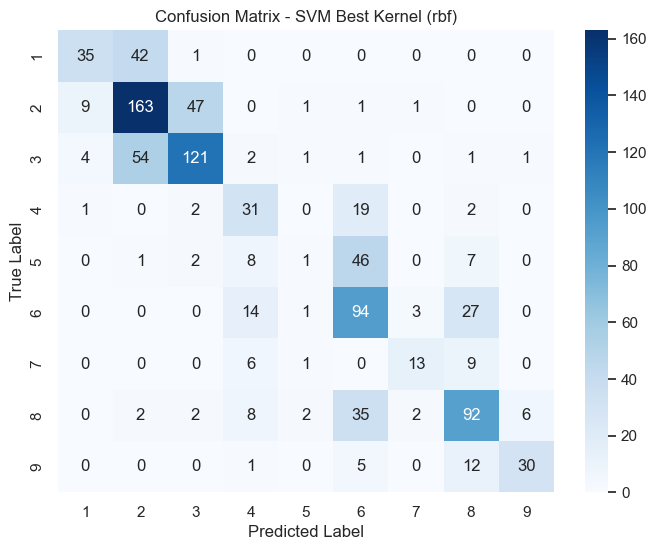

In [60]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define SVM kernels to test
kernels = ["linear", "poly", "rbf", "sigmoid"]
accuracy_scores = {}

# Train and evaluate SVM for each kernel
for kernel in kernels:
    svm_model = SVC(kernel=kernel, C=1, gamma="scale", random_state=42)
    svm_model.fit(X_train_SVM, y_train_SVM)
    y_pred_SVM = svm_model.predict(X_test_SVM)
    
    # Compute accuracy
    accuracy = accuracy_score(y_test_SVM, y_pred_SVM)
    accuracy_scores[kernel] = accuracy
    
    print(f"Kernel: {kernel}, Accuracy: {accuracy:.4f}")

# Convert results to DataFrame and display
accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=["Kernel", "Accuracy"])
print("\nSVM Kernel Performance:\n", accuracy_df)

# Identify the best kernel
best_kernel = max(accuracy_scores, key=accuracy_scores.get)
print(f"\nBest Performing Kernel: {best_kernel}")

# Train and predict with the best kernel
best_svm = SVC(kernel=best_kernel, C=1, gamma="scale", random_state=42)
best_svm.fit(X_train_SVM, y_train_SVM)
y_best_pred = best_svm.predict(X_test_SVM)

# Confusion Matrix
cm = confusion_matrix(y_test_SVM, y_best_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - SVM Best Kernel ({best_kernel})")
plt.show()


SVM Accuracy: 0.6258

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.50      0.60        78
           1       0.65      0.77      0.70       222
           2       0.71      0.67      0.69       185
           3       0.54      0.62      0.58        55
           4       0.33      0.09      0.14        65
           5       0.48      0.65      0.55       139
           6       0.70      0.55      0.62        29
           7       0.63      0.61      0.62       149
           8       0.79      0.77      0.78        48

    accuracy                           0.63       970
   macro avg       0.62      0.58      0.59       970
weighted avg       0.62      0.63      0.61       970



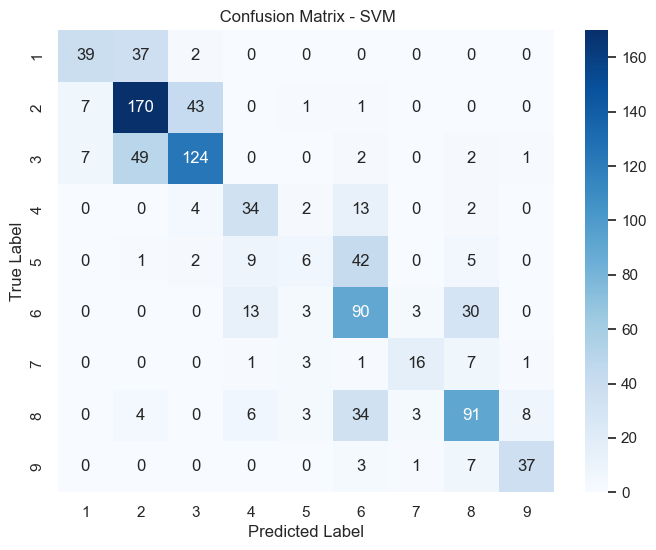

In [61]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Initialize the SVM model with RBF kernel (good for non-linear separation)
svm_model = SVC(kernel="rbf", C=7, gamma="scale", random_state=42)

# Train the model
svm_model.fit(X_train_SVM, y_train_SVM)

# Predict on test data
y_pred_SVM = svm_model.predict(X_test_SVM)

# Evaluate Model Performance
accuracy = accuracy_score(y_test_SVM, y_pred_SVM)
print(f"SVM Accuracy: {accuracy:.4f}")
SVM_report = classification_report(y_test_SVM, y_pred_SVM)
# Generate Classification Report
print("\nClassification Report:\n", SVM_report)

# Confusion Matrix
cm = confusion_matrix(y_test_SVM, y_pred_SVM)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(" Confusion Matrix - SVM")
plt.show()


### Predicting on Blind well

In [62]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 🔹 Define Features and Target
features = ["GR", "ILD_log10", "PE", "DeltaPHI", "PHIND", "NM_M"]
target = "Facies"

# 🔹 Split Training and Blind Well (NEWBY)
SVM_blind_well = well_data.copy()  # Ensure data integrity
SVM_train_wells = SVM_data[SVM_data["Well Name"] != "NEWBY"].copy()

# 🔹 Find All Unique Facies (Including Blind Well)
all_facies = sorted(pd.concat([SVM_train_wells["Facies"], SVM_blind_well["Facies"]]).unique())

# 🔹 Fit Label Encoder on Full Facies List
label_encoder = LabelEncoder()
label_encoder.fit(all_facies)  # Now it includes ALL facies

# 🔹 Encode Facies (Keeping Labels 1 to 9)
SVM_train_wells.loc[:, "Facies_Encoded"] = label_encoder.transform(SVM_train_wells["Facies"]) + 1
SVM_blind_well.loc[:, "Facies_Encoded"] = label_encoder.transform(SVM_blind_well["Facies"]) + 1

# 🔹 Extract Features & Target
SVM_X_train = SVM_train_wells[features]
SVM_y_train = SVM_train_wells["Facies_Encoded"]
SVM_X_blind = SVM_blind_well[features]

# 🔹 Standardize Features
scaler = StandardScaler()
SVM_X_train_scaled = scaler.fit_transform(SVM_X_train)
SVM_X_blind_scaled = scaler.transform(SVM_X_blind)

# 🔹 Train SVM Model (Using the Best Kernel)
svm_model = SVC(kernel="rbf", C=7, gamma="scale", random_state=42)
svm_model.fit(SVM_X_train_scaled, SVM_y_train)

# 🔹 Predict Facies for NEWBY Well
SVM_blind_well["SVM_Predicted_Facies"] = svm_model.predict(SVM_X_blind_scaled)

# 🔹 Convert Labels Back to Original Facies
SVM_blind_well["SVM_Predicted_Facies"] = label_encoder.inverse_transform(SVM_blind_well["SVM_Predicted_Facies"] )




### Plotting confusion matrix for SVM

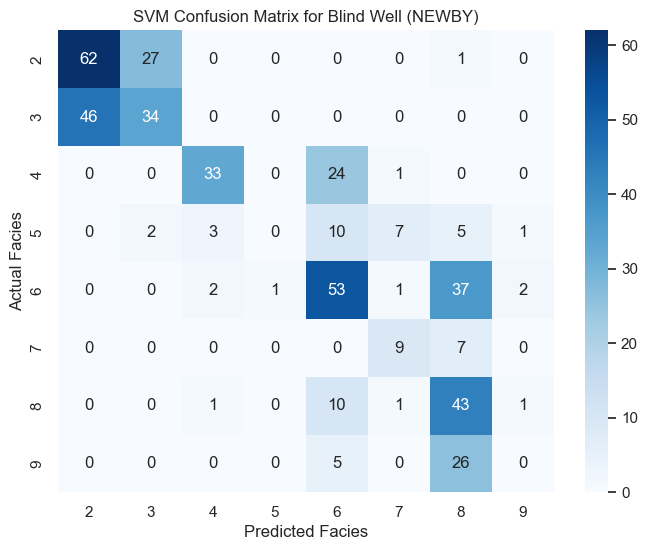

              precision    recall  f1-score   support

           2       0.57      0.63      0.60        98
           3       0.54      0.42      0.48        80
           4       0.85      0.57      0.68        58
           5       0.00      0.00      0.00        28
           6       0.52      0.55      0.54        96
           7       0.47      0.56      0.51        16
           8       0.36      0.77      0.49        56
           9       0.00      0.00      0.00        31

   micro avg       0.51      0.51      0.51       463
   macro avg       0.41      0.44      0.41       463
weighted avg       0.49      0.51      0.48       463

SVM Model Accuracy: 0.5054


In [63]:
# Ensure correct facies labels
y_pred_SVM= SVM_blind_well["SVM_Predicted_Facies"]
y_true_SVM = SVM_blind_well["Facies"]
all_facies = sorted(y_true_SVM.unique())  # Get unique actual facies values

# 🔹 Compute Confusion Matrix
conf_matrix_SVM = confusion_matrix(y_true_SVM, y_pred_SVM, labels=all_facies)

# 🔹 Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_SVM, annot=True, fmt="d", cmap="Blues", xticklabels=all_facies, yticklabels=all_facies)
plt.xlabel("Predicted Facies")
plt.ylabel("Actual Facies")
plt.title("SVM Confusion Matrix for Blind Well (NEWBY)")
plt.show()

# 🔹 Print Classification Report
print(classification_report(y_true_SVM, y_pred_SVM, labels=all_facies))

# 🔹 Compute & Print Accuracy
accuracy_SVM = accuracy_score(y_true_SVM, y_pred_SVM)
print(f"SVM Model Accuracy: {accuracy_SVM:.4f}")

### Log Visualisation

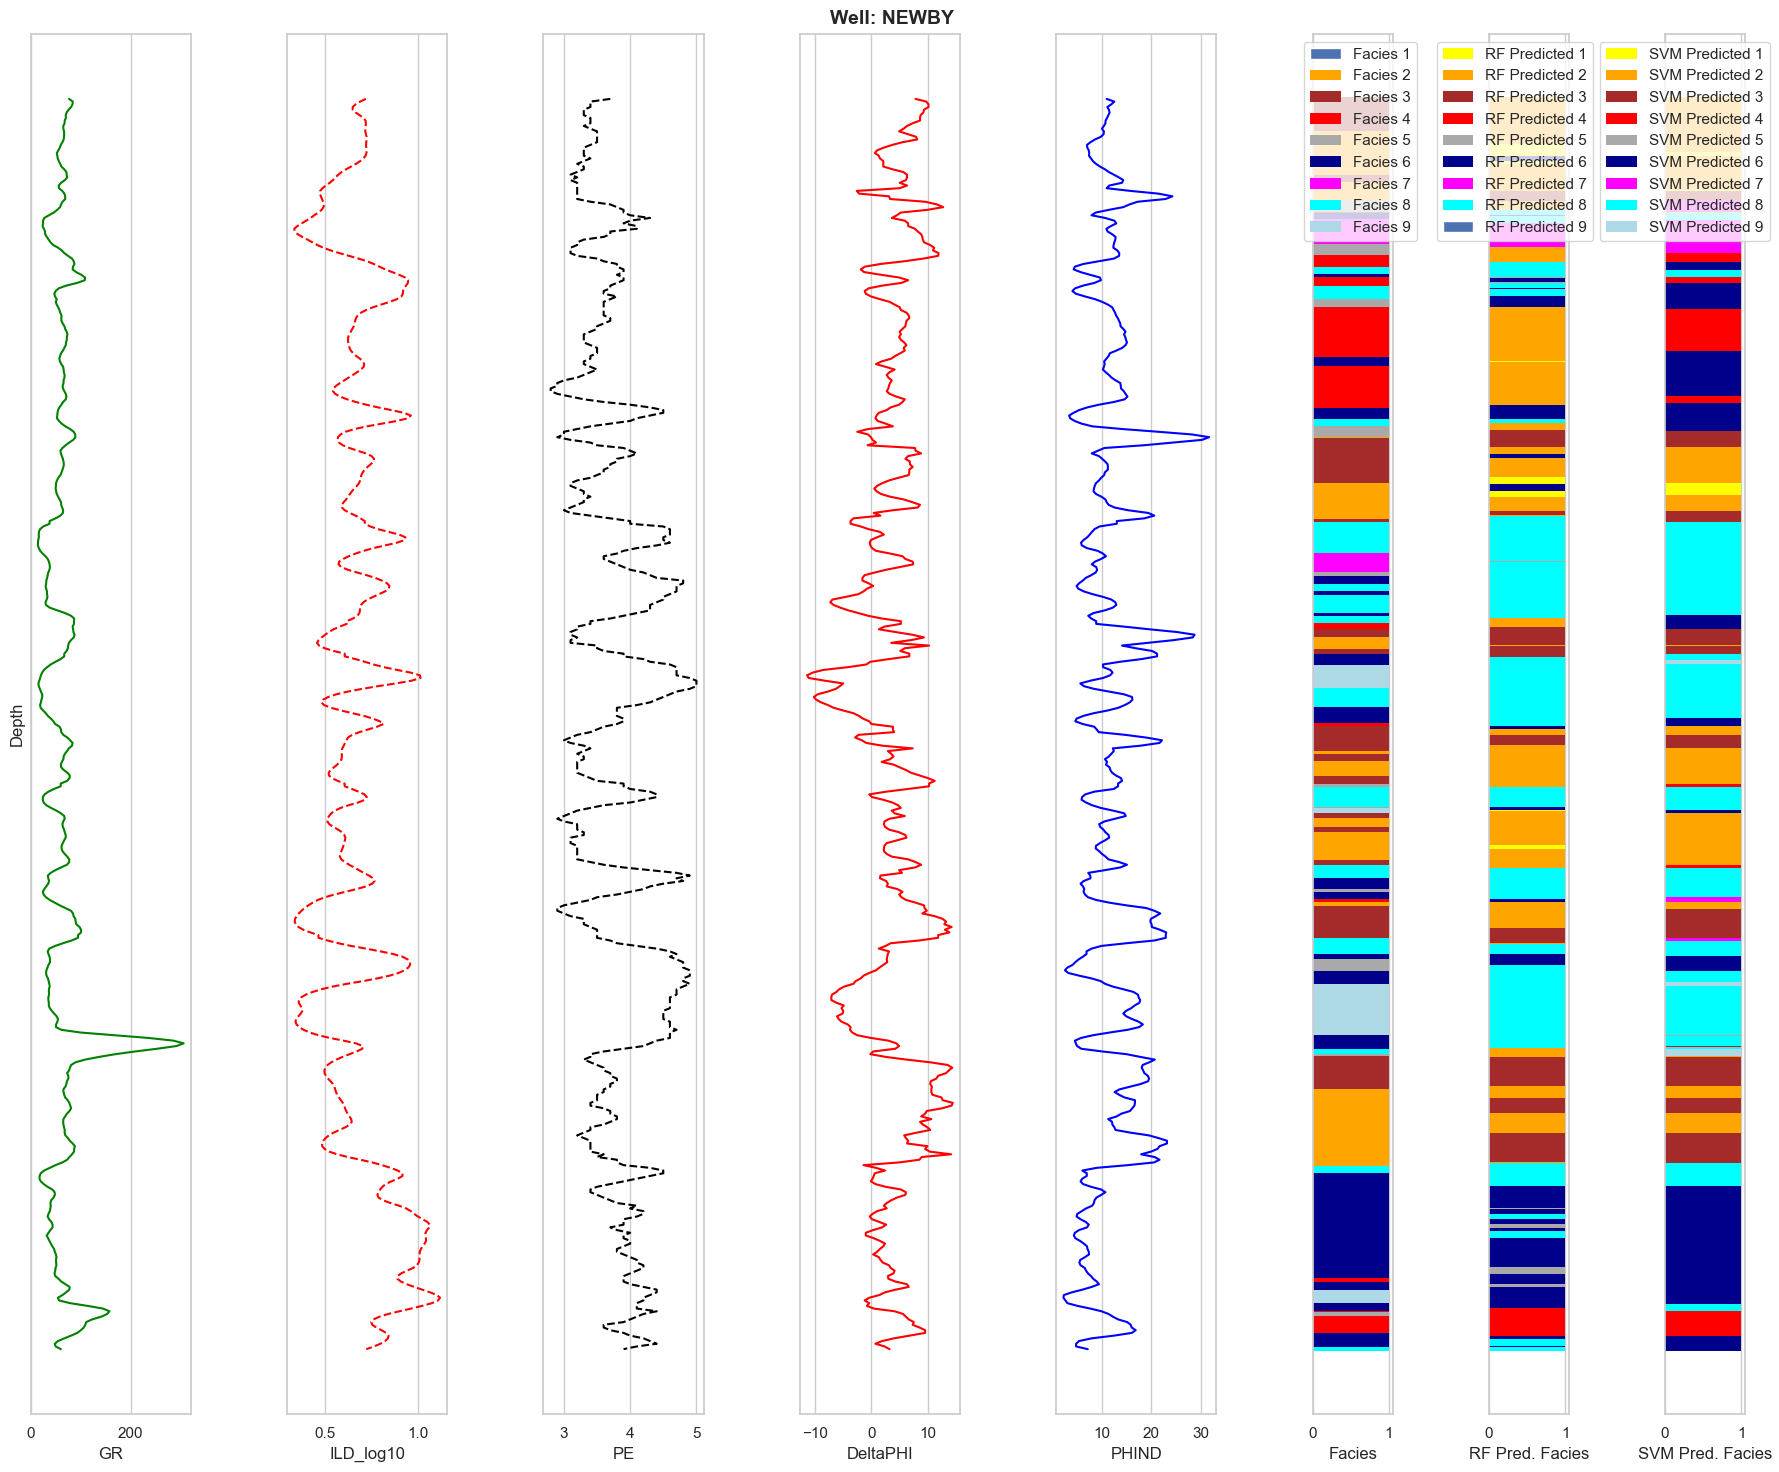

In [64]:
import matplotlib.pyplot as plt

# Ensure Depth is sorted in ascending order
SVM_blind_well = SVM_blind_well.sort_values(by=["Well Name", "Depth"])

# Define the logs to be plotted
logs = ["GR", "ILD_log10", "PE", "DeltaPHI", "PHIND"]  # Exclude "NM_M" and "RELPOS"
num_logs = len(logs)

# Define facies colors (assuming facies_colors is predefined)
facies_color_map = facies_colors  

# Define line styles and colors for each log
log_styles = {
    "GR": {"color": "green", "linestyle": "-"},
    "ILD_log10": {"color": "red", "linestyle": "--"},
    "PE": {"color": "black", "linestyle": "--"},
    "DeltaPHI": {"color": "red", "linestyle": "-"},
    "PHIND": {"color": "blue", "linestyle": "-"},
}

# Get unique well names
wells = SVM_blind_well["Well Name"].unique()

# Iterate over each well and create individual plots
for well in wells:
    well_data = SVM_blind_well[SVM_blind_well["Well Name"] == well]
    
    # Set up the figure and axes with increased vertical scale
    fig, axes = plt.subplots(1, num_logs + 3, figsize=(18, 15), sharey=True, gridspec_kw={'width_ratios': [1] * num_logs + [0.5, 0.5, 0.5]})
    fig.suptitle(f"Well: {well}", fontsize=14, fontweight='bold')
    
    # Plot each log
    for i, log in enumerate(logs):
        axes[i].plot(well_data[log], well_data["Depth"], label=log, **log_styles[log])
        axes[i].invert_yaxis()  # Depth increases downward
        axes[i].set_xlabel(log)
        axes[i].grid(True)
        if i == 0:
            axes[i].set_ylabel("Depth")
    
    # Add the actual facies track
    for facies, color in facies_color_map.items():
        mask = well_data["Facies"] == facies
        axes[-3].barh(
            well_data.loc[mask, "Depth"],
            1,
            left=0,
            color=color,
            edgecolor="none",
            label=f"Facies {facies}"
        )
    axes[-3].set_xlabel("Facies")
    axes[-3].set_yticks([])
    axes[-3].legend(loc="upper right", bbox_to_anchor=(1.4, 1))
    
    # Add the Random Forest predicted facies track
    for facies, color in facies_color_map.items():
        mask = well_data["Predicted_Facies"] == facies
        axes[-2].barh(
            well_data.loc[mask, "Depth"],
            1,
            left=0,
            color=color,
            edgecolor="none",
            label=f"RF Predicted {facies}"
        )
    axes[-2].set_xlabel("RF Pred. Facies")
    axes[-2].set_yticks([])
    axes[-2].legend(loc="upper right", bbox_to_anchor=(1.4, 1))
    
    # Add the SVM predicted facies track
    for facies, color in facies_color_map.items():
        mask = well_data["SVM_Predicted_Facies"] == facies
        axes[-1].barh(
            well_data.loc[mask, "Depth"],
            1,
            left=0,
            color=color,
            edgecolor="none",
            label=f"SVM Predicted {facies}"
        )
    axes[-1].set_xlabel("SVM Pred. Facies")
    axes[-1].set_yticks([])
    axes[-1].legend(loc="upper right", bbox_to_anchor=(1.4, 1))
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


Different logging tools have different vertical resolution, reasons why some facies < resolution may not be seen or may be mis matched
Facies was propably described from core descriprion, hence every details were accounted for

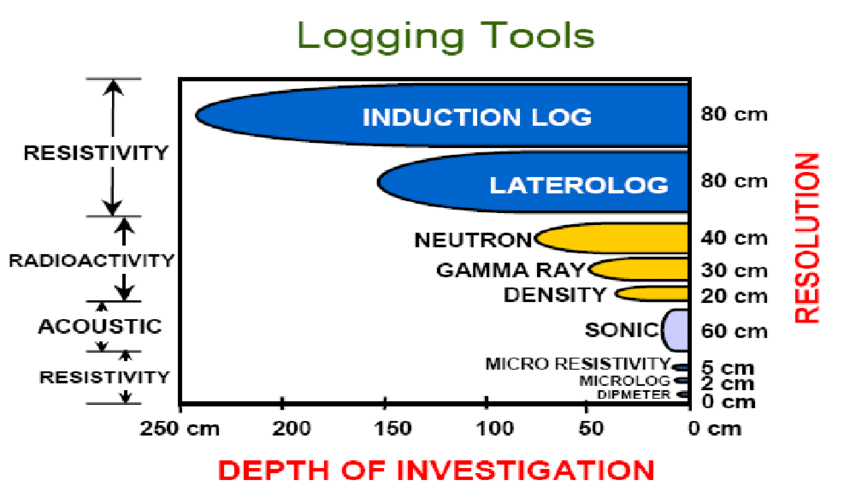

### Facies with high confusion: 

- 1-2 ( Nonmarine sandstone - Nonmarine coarse siltstone)
- 2-3 ( Nonmarine coarse siltstone - Nonmarine fine siltstone)
- 4-6 ( Marine siltstone and shale -  Wackestone (limestone))
- 6-8 (  Wackestone (limestone) - Packstone-grainstone (limestone))
- 8-9 ( Packstone-grainstone (limestone) - Phylloid-algal bafflestone (limestone))

1) Nonmarine sandstone
2) Nonmarine coarse siltstone
3) Nonmarine fine siltstone
4) Marine siltstone and shale
5) Mudstone (limestone)
6) Wackestone (limestone)
7) Dolomite
8) Packstone-grainstone (limestone)
9) Phylloid-algal bafflestone (limestone)


## Multilayer perceptron 

In [65]:
MLP_data=data.copy()
#blind_well=training_split_data[training_split_data['Well Name']=='NEWBY']
#train_wells =  training_split_data[training_split_data['Well Name']!='NEWBY']

### Running algorithm on all wells

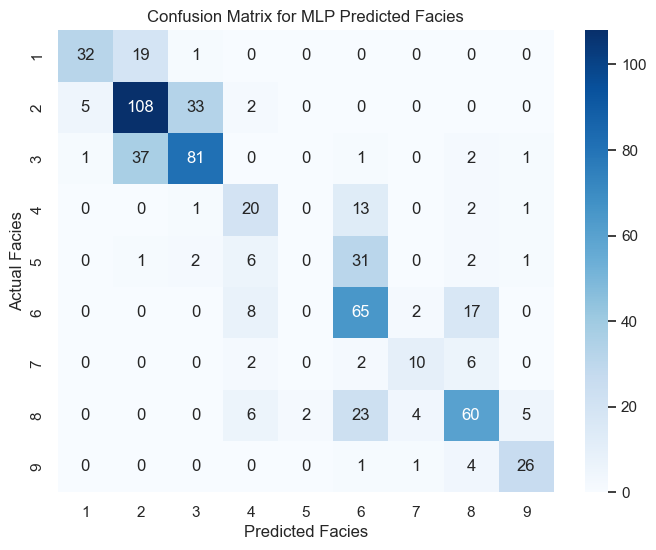

MLP Model Accuracy: 0.621

MLP Facies-wise Classification Report:
              precision  recall  f1-score  support
1                 0.842   0.615     0.711   52.000
2                 0.655   0.730     0.690  148.000
3                 0.686   0.659     0.672  123.000
4                 0.455   0.541     0.494   37.000
5                 0.000   0.000     0.000   43.000
6                 0.478   0.707     0.570   92.000
7                 0.588   0.500     0.541   20.000
8                 0.645   0.600     0.622  100.000
9                 0.765   0.812     0.788   32.000
accuracy          0.621   0.621     0.621    0.621
macro avg         0.568   0.574     0.565  647.000
weighted avg      0.598   0.621     0.604  647.000


In [66]:


# Encode Target Variable
label_encoder = LabelEncoder()
MLP_data["Facies_Encoded"] = label_encoder.fit_transform(data[target])

# Split Data into Train and Test Sets (80-20 ratio)
X_train, X_test, y_train, y_test = train_test_split(
    MLP_data[features], MLP_data["Facies_Encoded"], test_size=0.2, random_state=42, stratify=MLP_data["Facies_Encoded"]
)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and Train MLP Model
mlp_model = MLPClassifier(hidden_layer_sizes=(20,), activation="relu", solver="adam", max_iter=1000, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Predict on Test Set
y_pred = mlp_model.predict(X_test_scaled)

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Facies")
plt.ylabel("Actual Facies")
plt.title("Confusion Matrix for MLP Predicted Facies")
plt.show()

# Compute Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"MLP Model Accuracy: {accuracy:.3f}")

# Generate Classification Report
mlp_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
mlp_report_df = pd.DataFrame(mlp_report).T
print("\nMLP Facies-wise Classification Report:")
print(mlp_report_df.round(3))


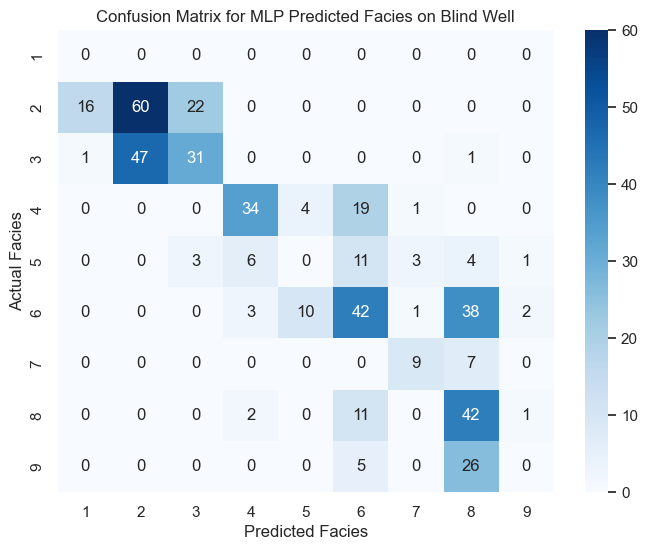

MLP Model Accuracy: 0.471

MLP Facies-wise Classification Report:
              precision  recall  f1-score  support
1                 0.000   0.000     0.000    0.000
2                 0.561   0.612     0.585   98.000
3                 0.554   0.388     0.456   80.000
4                 0.756   0.586     0.660   58.000
5                 0.000   0.000     0.000   28.000
6                 0.477   0.438     0.457   96.000
7                 0.643   0.562     0.600   16.000
8                 0.356   0.750     0.483   56.000
9                 0.000   0.000     0.000   31.000
accuracy          0.471   0.471     0.471    0.471
macro avg         0.372   0.371     0.360  463.000
weighted avg      0.473   0.471     0.459  463.000


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:

# Define Features and Target
features = ["GR", "ILD_log10", "PE", "DeltaPHI", "PHIND", "NM_M"]
target = "Facies"


# Ensure data integrity
MLP_blind_well =  well_data.copy()  # Ensure data integrity  
MLP_train_wells = MLP_data[MLP_data["Well Name"] != "NEWBY"].copy()
# Ensure copies before modifying
MLP_train_wells = MLP_train_wells.copy()
MLP_blind_well = MLP_blind_well.copy()

# Find All Unique Facies (Including Blind Well)
all_facies = sorted(pd.concat([MLP_train_wells["Facies"], MLP_blind_well["Facies"]]).unique())

# Fit Label Encoder on Full Facies List
label_encoder = LabelEncoder()
label_encoder.fit(all_facies)

# Encode Facies
MLP_train_wells.loc[:, "Facies_Encoded"] = label_encoder.transform(MLP_train_wells["Facies"]) + 1
MLP_blind_well.loc[:, "Facies_Encoded"] = label_encoder.transform(MLP_blind_well["Facies"])


# Extract Features & Target
MLP_X_train = MLP_train_wells[features]
MLP_y_train = MLP_train_wells["Facies_Encoded"]
MLP_X_blind = MLP_blind_well[features]

# Standardize Features
scaler = StandardScaler()
MLP_X_train_scaled = scaler.fit_transform(MLP_X_train)
MLP_X_blind_scaled = scaler.transform(MLP_X_blind)

# Define and Train MLP Model
mlp_model = MLPClassifier(hidden_layer_sizes=(20, ), activation="relu", solver="adam", max_iter=1000, random_state=42)
mlp_model.fit(MLP_X_train_scaled, MLP_y_train)

# Predict Facies for Blind Well
MLP_blind_well.loc[:, "MLP_Predicted_Facies"] = mlp_model.predict(MLP_X_blind_scaled)
MLP_blind_well.loc[:, "MLP_Predicted_Facies"] = label_encoder.inverse_transform(MLP_blind_well["MLP_Predicted_Facies"] - 1)

# Confusion Matrix for MLP
cm_mlp = confusion_matrix(MLP_blind_well["Facies"], MLP_blind_well["MLP_Predicted_Facies"], labels=all_facies)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues", xticklabels=all_facies, yticklabels=all_facies)
plt.xlabel("Predicted Facies")
plt.ylabel("Actual Facies")
plt.title("Confusion Matrix for MLP Predicted Facies on Blind Well")
plt.show()

# Compute Accuracy
mlp_accuracy = accuracy_score(MLP_blind_well["Facies"], MLP_blind_well["MLP_Predicted_Facies"])
print(f"MLP Model Accuracy: {mlp_accuracy:.3f}")

# Generate Classification Report
mlp_report = classification_report(MLP_blind_well["Facies"], MLP_blind_well["MLP_Predicted_Facies"], labels=all_facies, output_dict=True)

# Convert Report to DataFrame for Display
mlp_report_df = pd.DataFrame(mlp_report).T
print("\nMLP Facies-wise Classification Report:")
print(mlp_report_df.round(3))


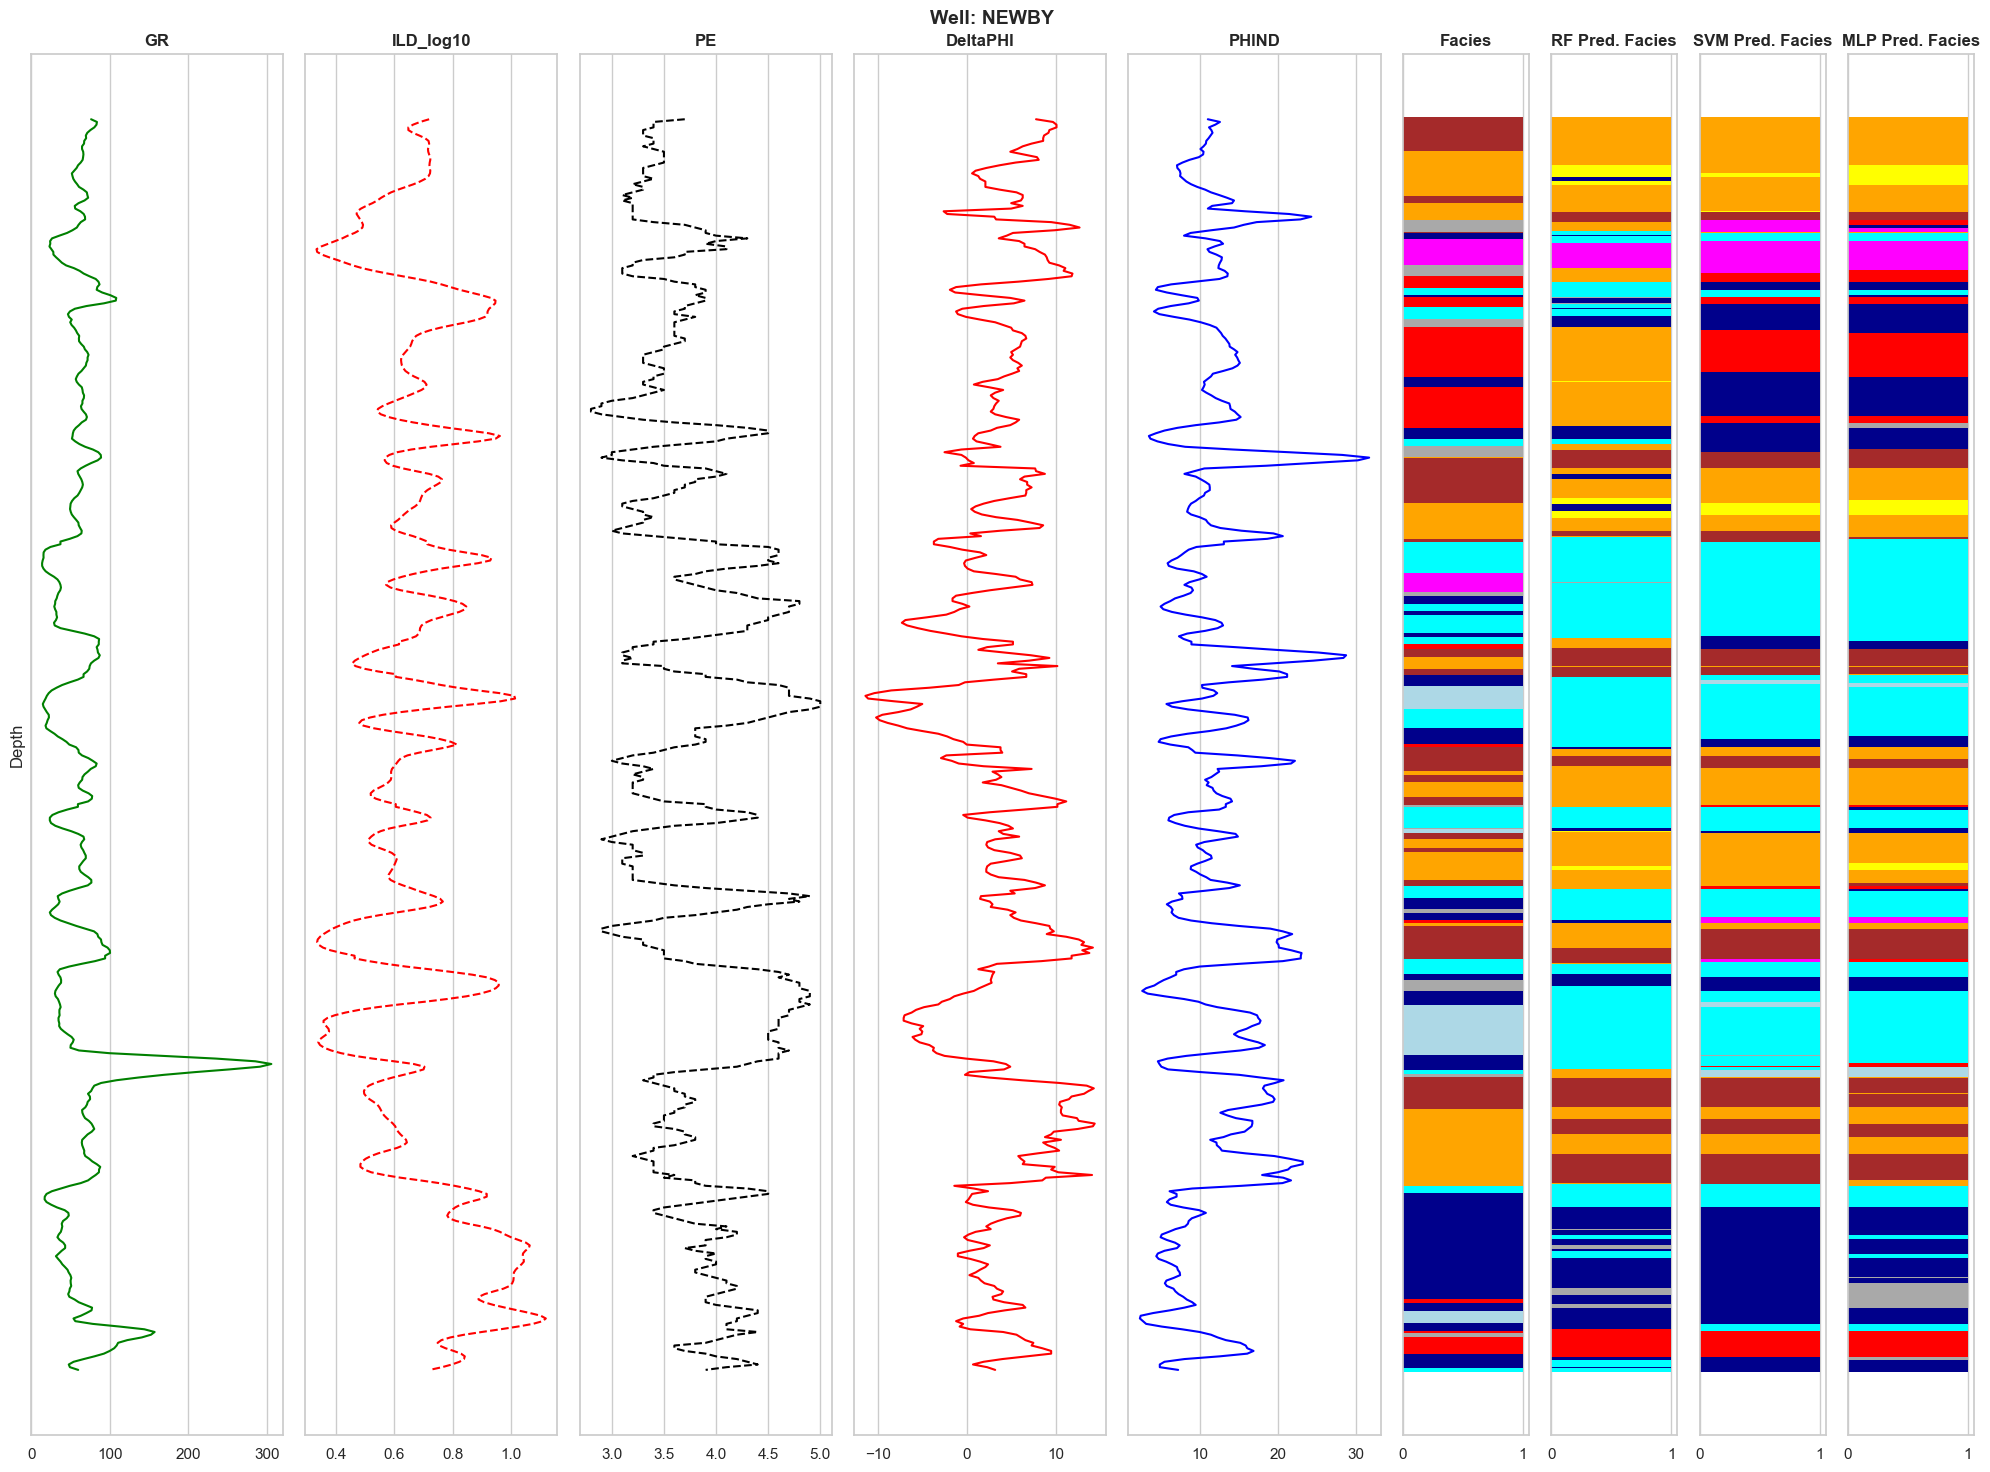

In [68]:
import matplotlib.pyplot as plt 
import numpy as np

# Ensure Depth is sorted in ascending order
MLP_blind_well = MLP_blind_well.sort_values(by=["Well Name", "Depth"])

# Define the logs to be plotted
logs = ["GR", "ILD_log10", "PE", "DeltaPHI", "PHIND"]
num_logs = len(logs)

# Define facies colors (assuming facies_colors is predefined)
facies_color_map = facies_colors  

# Define line styles and colors for each log
log_styles = {
    "GR": {"color": "green", "linestyle": "-"},
    "ILD_log10": {"color": "red", "linestyle": "--"},
    "PE": {"color": "black", "linestyle": "--"},
    "DeltaPHI": {"color": "red", "linestyle": "-"},
    "PHIND": {"color": "blue", "linestyle": "-"},
}

# Get unique well names
wells = MLP_blind_well["Well Name"].unique()

# Iterate over each well and create individual plots
for well in wells:
    well_data = MLP_blind_well[MLP_blind_well["Well Name"] == well]
    
    # Set up the figure and axes
    fig, axes = plt.subplots(1, num_logs + 4, figsize=(20, 15), sharey=True, 
                             gridspec_kw={'width_ratios': [1] * num_logs + [0.5, 0.5, 0.5, 0.5]})
    fig.suptitle(f"Well: {well}", fontsize=14, fontweight='bold')
    
    # Define depth tick positions (step of 50)
    min_depth, max_depth = well_data["Depth"].min(), well_data["Depth"].max()
    depth_ticks = np.arange(min_depth, max_depth + 1, 50)

    # Plot each log
    for i, log in enumerate(logs):
        axes[i].plot(well_data[log], well_data["Depth"], **log_styles[log])
        axes[i].invert_yaxis()  # Depth increases downward
        axes[i].set_title(log, fontsize=12, fontweight='bold')  # Title at the top
        axes[i].grid(True)

        if i == 0:  # Keep depth labels only on the first log
            axes[i].set_ylabel("Depth")
            axes[i].set_yticks(depth_ticks)  # Set depth tick labels
            axes[i].tick_params(axis="y", labelsize=10)
        else:
            axes[i].set_yticks([])

    
    facies_labels = ["Facies", "RF Pred. Facies", "SVM Pred. Facies", "MLP Pred. Facies"]
    facies_columns = ["Facies", "Predicted_Facies", "SVM_Predicted_Facies", "MLP_Predicted_Facies"]
    
    for j in range(4):
        for facies, color in facies_color_map.items():
            mask = well_data[facies_columns[j]] == facies
            axes[-4 + j].barh(
                well_data.loc[mask, "Depth"], 1, left=0,
                color=color, edgecolor="none"
            )
        axes[-4 + j].set_title(facies_labels[j], fontsize=12, fontweight='bold')  # Title at the top
        axes[-4 + j].set_yticks([])  # Remove tick labels

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
